# 1. Loading the Dataset

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    accuracy_score,
    roc_auc_score,
    roc_curve,
)

In [2]:
data = pd.read_csv('./Image_classification_data/data_labels_mainData.csv', sep=',', decimal='.')
print("Main Data Head")
display(data.head())

print(data['cellTypeName'].value_counts())
print(data['isCancerous'].value_counts())

Main Data Head


,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


cellTypeName
epithelial      4079
inflammatory    2543
fibroblast      1888
others          1386
Name: count, dtype: int64
isCancerous
0    5817
1    4079
Name: count, dtype: int64


## Evaluation Framework
### Data Splitting Strategy - Hold-Out validation

To begin, the dataset is split into training, validation, and test sets using a 60/20/20 ratio. Hold-out validation set (20% of training data) is used to evaluate performance of different parameters before testing on the final test set. This prevents information leakage and allows fair evaluation.
- Training Set (60%) is used to fit the model and learn the underlying patterns.
- Validation Set (20%) is used to tune hyperparameters (eg. apply techniques like regularisation, layer/filter tuning, early stopping) and guide model selection. 
- Test Set (20%) is reserved strictly for final evaluation to assess how the chosen model performs on completely unseen data.
 
### Prevention of Data Leakage
This splitting is performed before any preprocessing or modelling to avoid  data leakage. Applying these beforehand would allow techniques to “learn” from the test or validation sets, which biases model performance and undermines fairness in evaluation.

- If patient images appear in both training and test sets, the model may memorise patient-specific features instead of learning to generalise, this is data leakage. 
- It leads to inflated performance and poor real-world reliability. 
- To prevent **data leakage** and ensure realistic evaluation, we split the dataset using `GroupShuffleSplit` based on `patientID`. 
- This ensures that all images from a single patient are contained entirely within either the training, validation, or test set. 
- This mimics real-world deployment, where models must generalise to unseen patients, not just unseen images.

However, a drawback of this approach is that not all patients have all cell type images, making it difficult to maintain balanced class distributions in each subset. As a result, some splits may have class imbalance, but this trade-off is necessary to avoid overly optimistic performance estimates due to patient-specific feature memorization.


In [3]:
# Seeding is used to create predictable randomness during training for constant analysis
# This will not affect the testing procedures.
SEED = 32
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Perform Group Shuffle Split on Patient ID
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_val_idx, test_idx = next(gss.split(data, groups=data['patientID']))
train_val = data.iloc[train_val_idx]
test = data.iloc[test_idx]

gss_val = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=SEED)
train_idx, val_idx = next(gss_val.split(train_val, groups=train_val['patientID']))
train = train_val.iloc[train_idx]
val = train_val.iloc[val_idx]

print("Train data : {}, Val Data: {}, Test Data: {}".format(train.shape[0], val.shape[0], test.shape[0]))
print("Train images: {}, Val: {}, Test: {}".format(train.shape[0], val.shape[0], test.shape[0]))
print("Train patients: {}, Val: {}, Test: {}".format(train['patientID'].nunique(), val['patientID'].nunique(), test['patientID'].nunique()))

train_labels = train['isCancerous'].astype(int).values
val_labels = val['isCancerous'].astype(int).values
test_labels = test['isCancerous'].astype(int).values

y_train = train['cellTypeName'].values
y_val = val['cellTypeName'].values
y_test = test['cellTypeName'].values

Train data : 5616, Val Data: 2205, Test Data: 2075
Train images: 5616, Val: 2205, Test: 2075
Train patients: 36, Val: 12, Test: 12


# 2. Exploratory Data Analysis (EDA)
### 2.1 Class Imbalance Identification

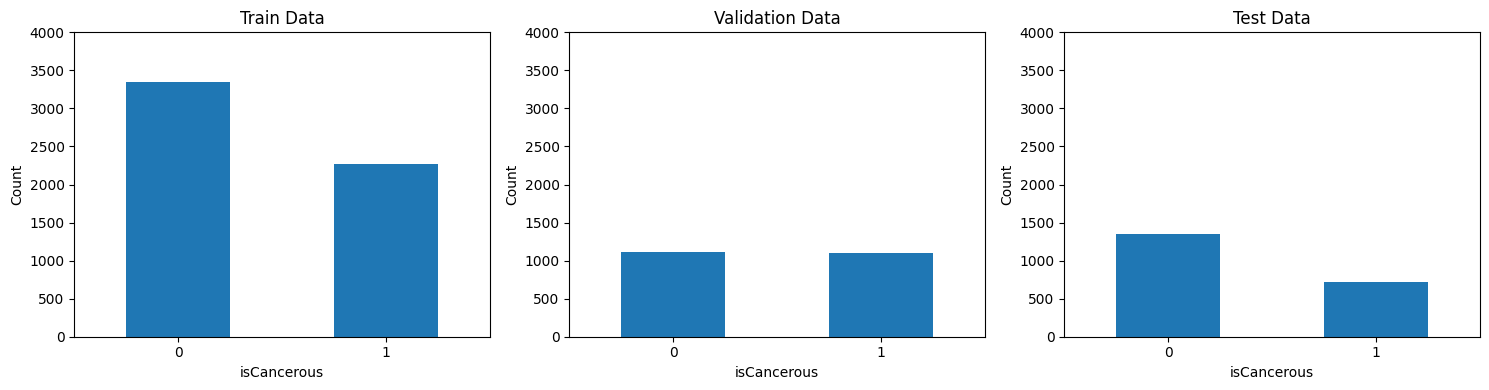

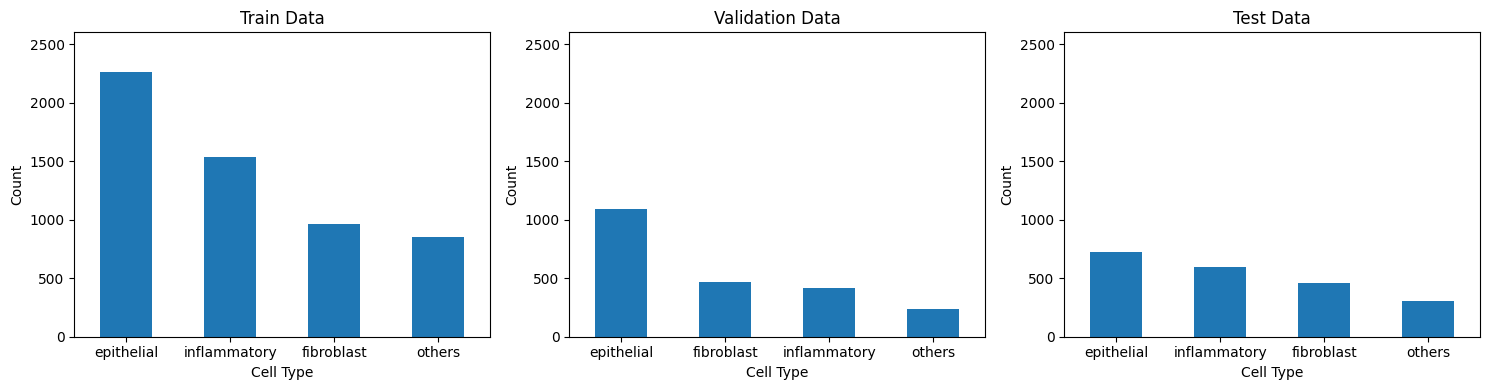

In [4]:
titles = ['Train Data', 'Validation Data', 'Test Data']
datasets = [train, val, test]

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for ax, title, data in zip(axs, titles, datasets):
    class_count = data['isCancerous'].value_counts().sort_index()
    class_count.plot(kind='bar', ax=ax)
    ax.set_title(f'{title}')
    ax.set_xlabel('isCancerous')
    ax.set_ylabel('Count')
    ax.set_xticks(range(len(class_count)))
    ax.set_xticklabels(class_count.index, rotation=0)
    ax.set_ylim(0,4000)

plt.tight_layout()
plt.show()


titles = ['Train Data', 'Validation Data', 'Test Data']
datasets = [train, val, test] 

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for ax, title, data in zip(axs, titles, datasets):
    class_count = data['cellTypeName'].value_counts()
    class_count.plot(kind='bar', ax=ax)
    ax.set_title(f'{title}')
    ax.set_xlabel('Cell Type')
    ax.set_ylabel('Count')
    ax.set_xticklabels(class_count.index, rotation=0)
    ax.set_ylim(0,2600)

plt.tight_layout()
plt.show()

> <span style="font-size:1em;">✔</span> **Observations:** 

When some categories have significantly more examples than others, a multiclass classifcation can turn behave biased, that over-predicts dominant classes and underperforms on minority ones. Identifying imbalance is crucial to apply appropriate techniques to ensure fairness and generalisability across all cell types. The bar plots above show the number of samples per cell_type in each data split:
- In all sets, Epithelial is the most frequent class, with over 2400 samples in training.
- Others have notably fewer samples (~1000–1300).
- This clearly shows <span style="color:red">**class imbalance**</span>, which can reduce the model's ability to accurately classify underrepresented classes like "Others".

#### Handling Class Imbalance
To address this imbalance and ensure the model treats all cell types fairly, this informs us to:
- Apply class weighting to penalise errors on rare classes more heavily
- Use macro-averaged F1-score during evaluation to give equal weight to all classes
- Experiment with data augmentation for low-sample classes to increase diversity and robustness

#### Performance Metrics Selection

Because we see that there is clear class imbalance, using <span style="color:red">**macro F1-score**</span> is important as it treats all classes equally, regardless of how many samples they have. Unlike accuracy, it ensures that performance on minority classes is reflected in the overall score, giving a more balanced and reliable evaluation.

### 2.2 Image Sampling

Visualising sample images helps us understand how cell types differ in texture and appearance, and confirms that labels are visually consistent. This step is useful for spotting patterns, identifying noisy samples, and guiding model complexity. By observing actual samples, we can:
- Confirm that the image labels match the visual appearance.
- Assess whether cell types differ clearly in shape, texture, and colour.
- Identify potential challenges (e.g., subtle variations, noisy images, or low inter-class variance).

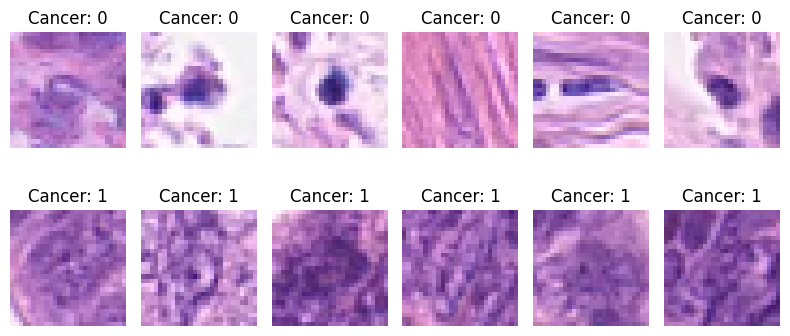

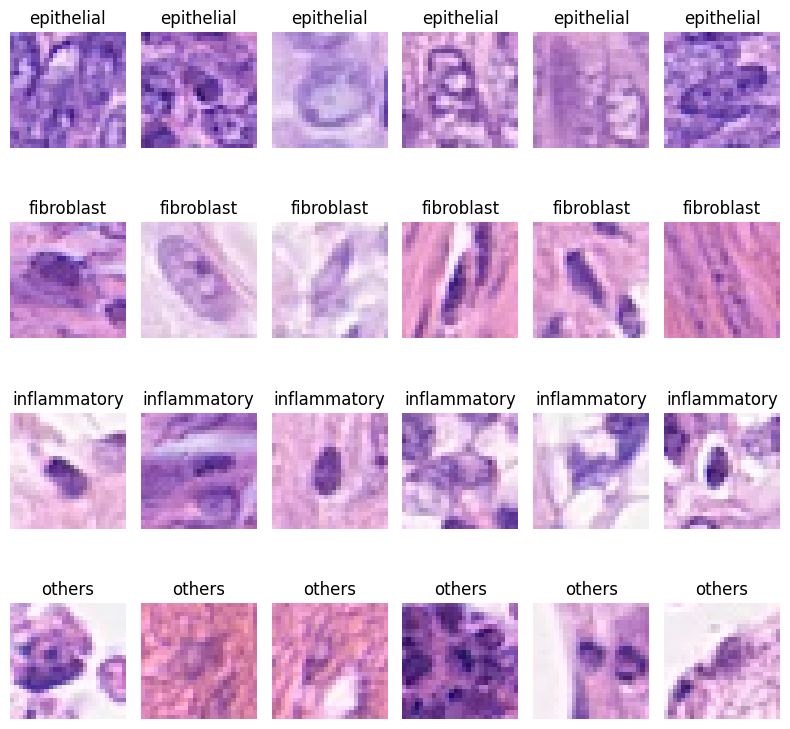

In [5]:
image_dir = './Image_classification_data/patch_images/'

# Random sample from each class
cancer_0 = train[train['isCancerous'] == 0].sample(n=6)
cancer_1 = train[train['isCancerous'] == 1].sample(n=6)

sample_df = pd.concat([cancer_0, cancer_1]).reset_index(drop=True)

plt.figure(figsize=(8, 4))
for i, (idx, row) in enumerate(sample_df.iterrows()):
    img_path = os.path.join(image_dir, row['ImageName'])
    img = mpimg.imread(img_path) 
    row_num = 0 if row['isCancerous'] == 0 else 1
    col_num = i % 6
    plt.subplot(2, 6, row_num * 6 + col_num + 1)
    plt.imshow(img)
    plt.title(f"Cancer: {row['isCancerous']}")
    plt.axis('off')

plt.tight_layout()
plt.show()



# Sample 6 images from each cell type class (0–3)
sample_images = []
for label in sorted(train['cellTypeName'].unique()):
    samples = train[train['cellTypeName'] == label].sample(n=6, random_state=SEED)
    sample_images.append(samples)

sample_df = pd.concat(sample_images).reset_index(drop=True)

# Plot the images
plt.figure(figsize=(8, 8))
for i, (idx, row) in enumerate(sample_df.iterrows()):
    img_path = os.path.join(image_dir, row['ImageName'])
    img = mpimg.imread(img_path)
    plt.subplot(4, 6, i + 1)
    plt.imshow(img)
    plt.title(row['cellTypeName'])
    plt.axis('off')

plt.tight_layout()
plt.show()

> <span style="font-size:1em;">✔</span> **Observations:** 
The image grid above shows four samples each from:
- Epithelial: elongated, oval-like shape, often structured textures
- Fibroblast: often streaked and elongated shapes
- Inflammatory: more granular and clustered appearance
- Others: heterogeneous and less consistent in appearance

These observations highlight that while some cell types (e.g. epithelial vs inflammatory) have distinguishable features, others may overlap, increasing the classification difficulty. This justifies our choice to use Convolutional Neural Networks, which excel in capturing spatial patterns and fine-grained textures across image classes. Visual Issues Observed:
- Blurry images: Some patches (especially fibroblast, others) are out of focus → harms detail learning.
- Lighting/tint variation: Uneven staining and brightness can mislead the model.
- Occlusion/cropping: Some cells are cut off, losing key features.
- Noise/artefacts: Background clutter or dark spots (e.g. in "others") may confuse the model.
- LIMITATION: "Others" inconsistency: There are some clustered, circular-like/ elongated-like that could be mistaken for inflammatory, fibroblast, or epithelial cells

 ### 2.3 Pixel-Level Analysis by Cell Type

Pixel-level analysis helps us understand colour intensity patterns across cell types, and whether visual differences are reflected in raw pixel distributions. We analysed pixel intensity distributions across the three RGB channels for each cell type: **Epithelial, Inflammatory, Fibroblast**, and **Others**. We computed histograms of RGB pixel intensities for each cell_type using all training images, observing how colours vary across classes. 

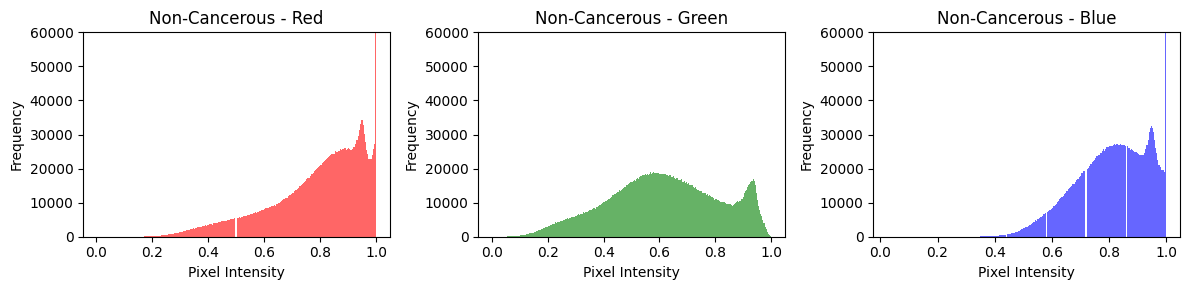

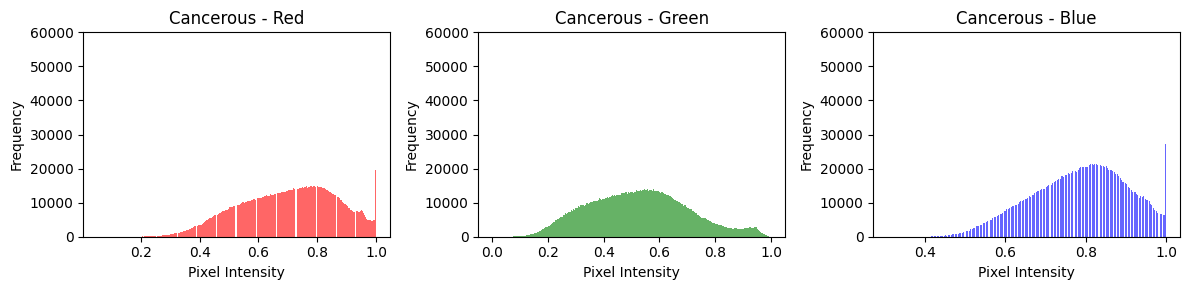

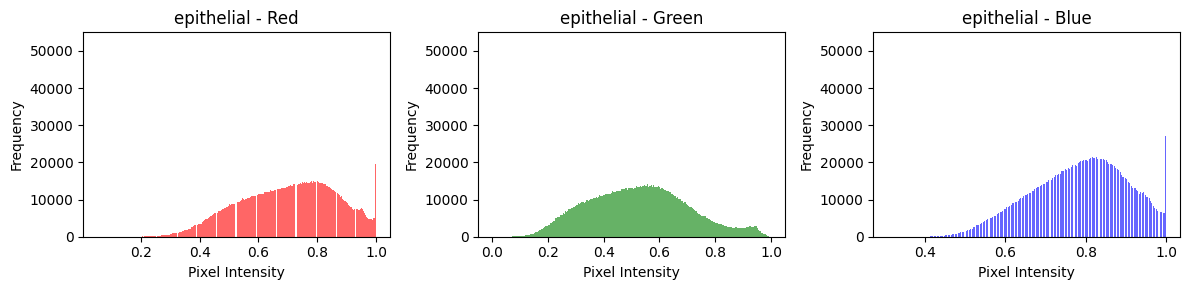

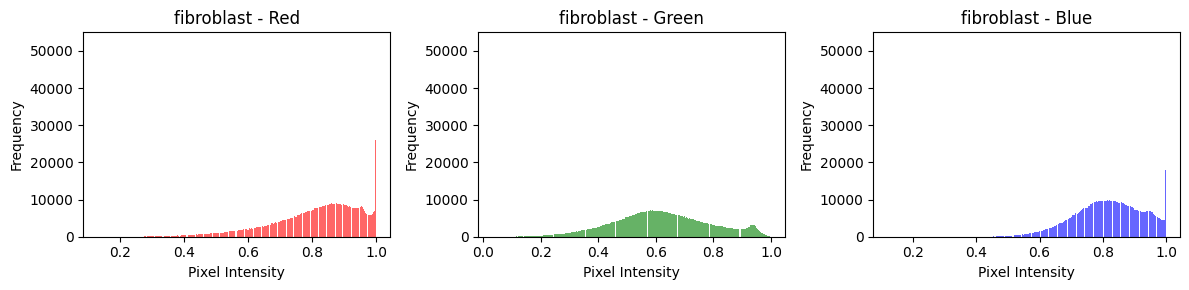

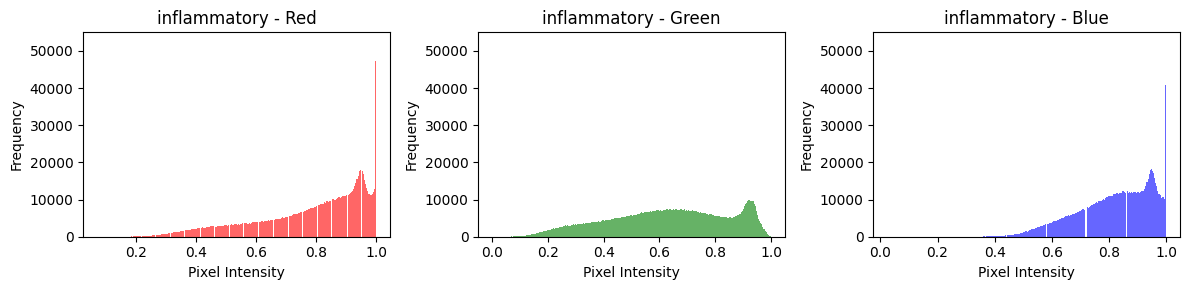

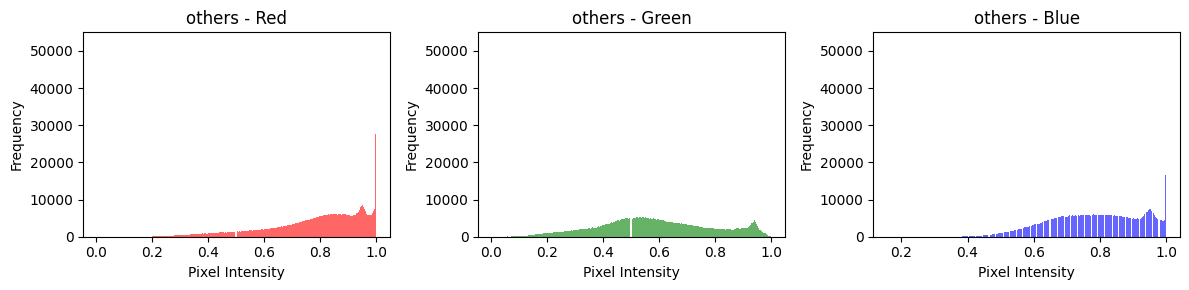

In [6]:

"""
Plots RGB pixel intensity histograms for each class.

Args:
    paths: list or np.array of image filenames
    labels: list or np.array of labels (strings or ints)
    class_names: list of class names or mapping
    image_dir: directory where images are stored
    y_max: maximum y-limit for histograms
"""
def plot_pixel_histograms(paths, labels, class_names, image_dir, y_max=60000):

    for label in sorted(np.unique(labels)):
        # Get paths for current class
        class_paths = paths[labels == label]
        
        # Load all images for this class
        all_pixels = [mpimg.imread(os.path.join(image_dir, p)) for p in class_paths]
        all_pixels = np.stack(all_pixels)

        # Plot histograms
        fig, axs = plt.subplots(1, 3, figsize=(12, 3))
        for i, color in enumerate(['Red', 'Green', 'Blue']):
            axs[i].hist(all_pixels[..., i].ravel(), bins=256, color=color.lower(), alpha=0.6)
            class_label = class_names[label] if isinstance(label, (int, np.integer)) else label
            axs[i].set_title(f'{class_label} - {color}')
            axs[i].set_xlabel('Pixel Intensity')
            axs[i].set_ylabel('Frequency')
            axs[i].set_ylim(0, y_max)

        plt.tight_layout()
        plt.show()

# ---- Usage ----

image_dir = './Image_classification_data/patch_images/'

# Binary labels
plot_pixel_histograms(
    paths=train['ImageName'].values,
    labels=train['isCancerous'].values,
    class_names=["Non-Cancerous", "Cancerous"],
    image_dir=image_dir,
    y_max=60000
)

# Multi-class labels
plot_pixel_histograms(
    paths=train['ImageName'].values,
    labels=train['cellTypeName'].values,
    class_names=None,  # labels are already descriptive (strings)
    image_dir=image_dir,
    y_max=55000
)


> <span style="font-size:1em;">✔</span> **Observations:** 


The histograms reveal subtle differences in channel intensity spread, suggesting that:

- The histograms shows obvious differences in pixel intensity distributions between cancerous and non-cancerous samples across the red, green, and blue color channels. Non-cancerous samples seem to have sharper peaks in their pixel intensity histograms across all three color channels, while the cancerous samples show broader, more spread-out distributions.
-  RGB values already in range [0,1], therefore normalisation is not required.

- All cell types show peaks in the higher intensity range (0.6–1.0).
- **Fibroblast** and **Inflammatory** have broader red and green distributions.
- **Epithelial** appears more sharply peaked, especially in the blue channel.
- **Others** class shows a flatter, more scattered intensity range, suggesting visual diversity.

These patterns suggest that visual and colour-based differences exist between cell types, which supports the use of RGB inputs and Convolutional Neural Networks for this task.

 ### 2.4 Bivariate Analysis

To understand how image features relate to cell types, we used pair plots showing the mean and standard deviation of the RGB channels.

We found that some feature pairs (like mean_r vs mean_b) helped separate epithelial and fibroblast cells. However, inflammatory and others were harder to distinguish, with more overlap between them.

This suggests using all RGB channels in training is helpful, and that data augmentation may be needed to better separate the harder classes.

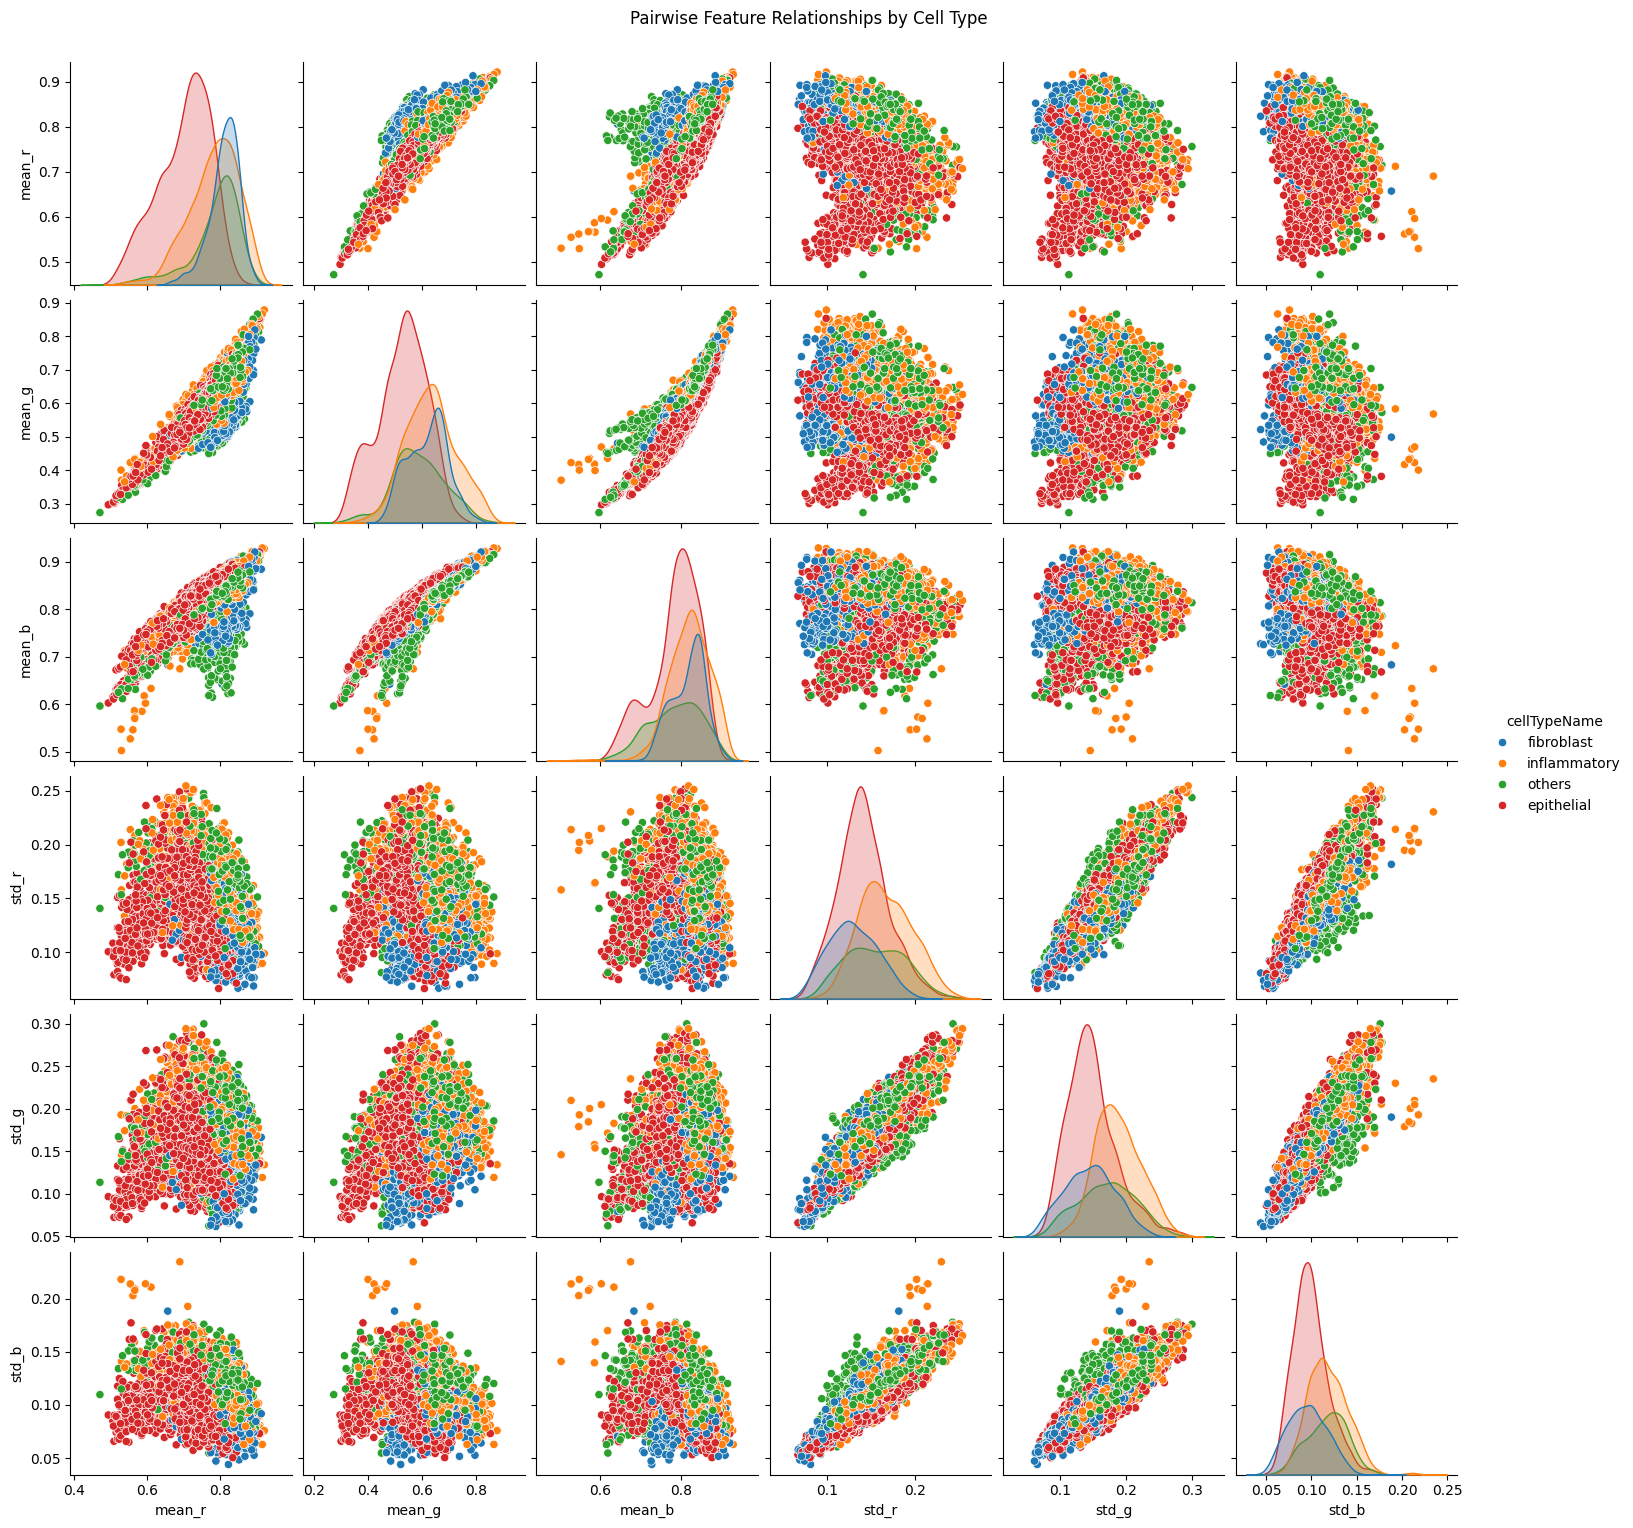

In [7]:
def extract_features(df):
    features = []
    for _, row in df.iterrows():
        img_path = os.path.join(image_dir, row['ImageName'])
        img = mpimg.imread(img_path)

        mean_r = np.mean(img[..., 0])
        mean_g = np.mean(img[..., 1])
        mean_b = np.mean(img[..., 2])
        std_r = np.std(img[..., 0])
        std_g = np.std(img[..., 1])
        std_b = np.std(img[..., 2])

        features.append([mean_r, mean_g, mean_b, std_r, std_g, std_b, row['cellTypeName']])

    return pd.DataFrame(features, columns=[
        'mean_r', 'mean_g', 'mean_b', 'std_r', 'std_g', 'std_b', 'cellTypeName'
    ])

feature_df = extract_features(train)

import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(feature_df, hue='cellTypeName', vars=['mean_r', 'mean_g', 'mean_b', 'std_r', 'std_g', 'std_b'])
plt.suptitle("Pairwise Feature Relationships by Cell Type", y=1.02)
plt.show()

# 3. Pre-processing

### 3.1 Justification of Data Handling Methods

We used class weights to handle class imbalance, as it allows the model to give more importance to underrepresented classes during training without modifying the data itself. Unlike oversampling or undersampling, which can introduce redundancy or lose valuable examples, class weighting preserves the full dataset while encouraging balanced learning. This is especially useful in medical image tasks where every sample is informative and data is limited.

Moreover as seen in the EDA, all pixel values are already normalised [0,1]. Later on in model development `ImageDataGenerator(rescale=1.0/255.0)` would suffice this rescaling

In [8]:

weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = {i: weights[i] for i in range(len(weights))}
print(class_weights)

classes = np.unique(y_train)  # raw labels (not one-hot)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, weights))
print(class_weight_dict)

{0: np.float64(0.8379588182632051), 1: np.float64(1.2397350993377483)}
{'epithelial': np.float64(0.6198675496688741), 'fibroblast': np.float64(1.4549222797927461), 'inflammatory': np.float64(0.9128738621586476), 'others': np.float64(1.6556603773584906)}


# 4. Baseline Model

### 4.1 Binary Classification (isCancerous)

Convolutional neural network  CNN modals are know to be suitable for image classification tasks due to their ability to capture spatial hierarchies through local connectivity and weight sharing, which helps extract meaningful patterns such as textures and shapes.

- Architecture:
    * The CNN modal begins with convolutional layer with 32 filters of size 3×3, capturing low-level patterns such as edges and cell boundaries, which are important for identify cell structures. It is then followed by a 2x2 max-pooling layer, which helps the model recognize features even if the cell is slightly shifted in the image. The following second convolutional layer with 64 filters captures higher-level abstract features, such as unusual shapes or changes in the way the cells look that are common in cancerous cells, and again followed by max-pooling. The resulting features are then flattened and passed through a dense layer with 512 ReLU-activated units, and finally through a sigmoid-activated output neuron for binary classification. 

- Optimization: 
    * Both models are optimized using the Adam optimizer and trained with a binary cross-entropy loss function. To mitigate class imbalance, class weights were applied during training, which was conducted over 50 epochs.

- Evaluation Metrics:
    * Accuracy: The percentage of correctly classified images out of the total number of images. It gives a general idea of performance, but can be misleading if datasets are imbalanced, such as predicting all images as non-cancerous could still get high accuracy if most images are non-cancerous.

    * Macro Precision: The percentage of how many predicted positives are actually correct averaged across both classes equally. High precision means the model doesn't generate too many false positives, but might lead to underkill.

    * Macro Recall: The percentage of how many actual positives were correctly predicted averaged across both classes equally. High recall is especially important in medical diagnosis to reduce the chances of missing cancerous cells, but might lead to overkill.

    * Macro F1-Score: The harmonic mean of precision and recall, averaged equally across both classes. It provides a balanced measure that accounts for both false positives and false negatives, making it especially useful when the data is imbalanced and both classes are important.

    * ROC-AUC Score: The Area Under the Receiver Operating Characteristic (ROC) Curve, which evaluates the model’s ability to distinguish between cancerous and non-cancerous cells across all thresholds. A higher AUC score (closer to 1) indicates better separation between the two classes.

### Data Generator 

we used Keras `ImageDataGenerator` to create data pipelines. Both the training and validation images are loaded using `flow_from_dataframe`, which reads file names and labels from dataframes. The images are loaded in batches of 32, each image is resized to a fixed size of 27×27 pixels, whitch matches the given dataset. The data is labeled in binary mode, as the task is to classify images as either cancerous (1) or non-cancerous (0). Shuffling is disabled to maintain the order between predictions and actual labels during evaluation.

In [9]:
train_isCancer = train.copy()
val_isCancer = val.copy()

train_isCancer.loc[:, 'isCancerous'] = train_isCancer['isCancerous'].astype(str)
val_isCancer.loc[:, 'isCancerous'] = val_isCancer['isCancerous'].astype(str)

train_isCancer_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_isCancer_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

train_isCancer_generator = train_isCancer_datagen.flow_from_dataframe(
    dataframe=train_isCancer,
    directory = './Image_classification_data/patch_images/',
    x_col="ImageName",
    y_col="isCancerous",
    target_size=(27, 27),
    batch_size=32,
    class_mode='binary',
    shuffle=False, 
)

val_isCancer_generator = val_isCancer_datagen.flow_from_dataframe(
    dataframe=val_isCancer,
    directory = './Image_classification_data/patch_images/',
    x_col="ImageName",
    y_col="isCancerous",
    target_size=(27, 27),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
)

Found 5616 validated image filenames belonging to 2 classes.
Found 2205 validated image filenames belonging to 2 classes.


/var/folders/ps/y3jw1ysn15x1631155827z0m0000gn/T/ipykernel_297/2772510441.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['0' '0' '0' ... '0' '0' '0']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_isCancer.loc[:, 'isCancerous'] = train_isCancer['isCancerous'].astype(str)
/var/folders/ps/y3jw1ysn15x1631155827z0m0000gn/T/ipykernel_297/2772510441.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['0' '0' '0' ... '1' '1' '1']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  val_isCancer.loc[:, 'isCancerous'] = val_isCancer['isCancerous'].astype(str)


### Helper Functions for Binary Classification Evaluation 

In [10]:
# Function to display learing curve
def learning_curve(train_loss, val_loss, train_acc, val_acc):
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, 'r--')
    plt.plot(val_acc, 'b--')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.tight_layout()
    plt.show()


# Function to print out evaluation summary
def evaluate_binary_model(model, data_generator, true_labels):
    # Ensure generator is not shuffled
    data_generator.shuffle = False
    pred = model.predict(data_generator).ravel()
    pred_binary = (pred > 0.5).astype(int) # Convert probabilities to binary predictions

    report = classification_report(true_labels, pred_binary, target_names=["Non-Cancer", "Cancer"], output_dict=True)

    print("Classification Metrics Summary:\n")
    print(f"Accuracy       : {report['accuracy']:.2f}")
    print(f"Macro F1-score : {report['macro avg']['f1-score']:.2f}")
    print(f"Macro Precision: {report['macro avg']['precision']:.2f}")
    print(f"Macro Recall   : {report['macro avg']['recall']:.2f}")
    print(f"ROC-AUC Score  : {roc_auc_score(true_labels, pred):.2f}")


def evaluate_binary_matrix(model, data_generator, true_labels):
    data_generator.shuffle = False
    preds = model.predict(data_generator).ravel()
    preds_binary = (preds > 0.5).astype(int)

    cm = confusion_matrix(true_labels, preds_binary)
    fig, ax = plt.subplots(figsize=(5,3)) 
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Cancer", "Cancer"])
    disp.plot(cmap='Blues', ax=ax)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


def binary_roc_curve(model, data_generator, true_labels):
    data_generator.shuffle = False
    pred = model.predict(data_generator).ravel()

    # Compute ROC curve and ROC area
    fpr, tpr, thresholds = roc_curve(true_labels, pred)
    roc_auc = roc_auc_score(true_labels, pred)

    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label='ROC curve', color='blue')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic Curve\nAUC = {roc_auc:.2f}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Setup Layers and Compile MLP Model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 2187)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,120,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,120,769 (4.28 MB)

 Trainable params: 1,120,769 (4.28 MB)

 Non-trainable params: 0 (0.00 B)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Classification Metrics Summary:

Accuracy       : 0.75
Macro F1-score : 0.74
Macro Precision: 0.81
Macro Recall   : 0.75
ROC-AUC Score  : 0.94


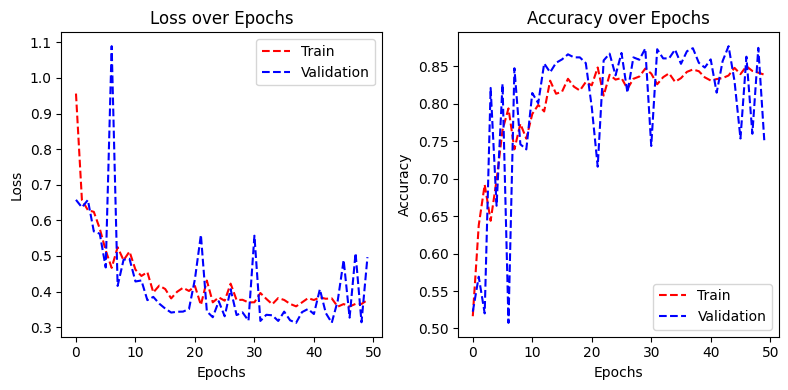

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


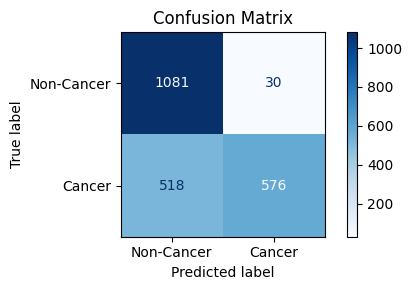

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


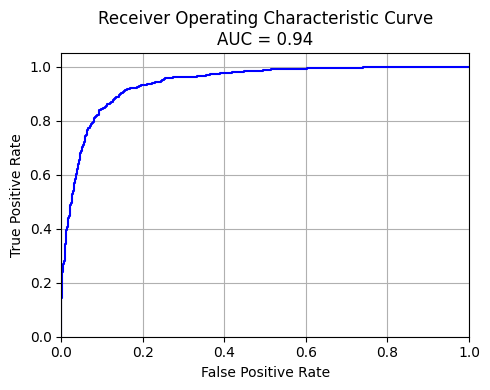

In [11]:
model_MLP = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model_MLP.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_MLP.summary()

history_MLP = model_MLP.fit(
    train_isCancer_generator,
    validation_data=val_isCancer_generator,
    epochs=50,
    verbose=0,
    class_weight=class_weights
)

evaluate_binary_model(model_MLP, val_isCancer_generator, val_labels)
learning_curve(
    history_MLP.history['loss'],
    history_MLP.history['val_loss'],
    history_MLP.history['accuracy'],
    history_MLP.history['val_accuracy']
)
evaluate_binary_matrix(model_MLP, val_isCancer_generator, val_labels)
binary_roc_curve(model_MLP, val_isCancer_generator, val_labels)

### Setup Layers and Compile CNN Model

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 27, 27, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,200,065 (4.58 MB)

 Trainable params: 1,200,065 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

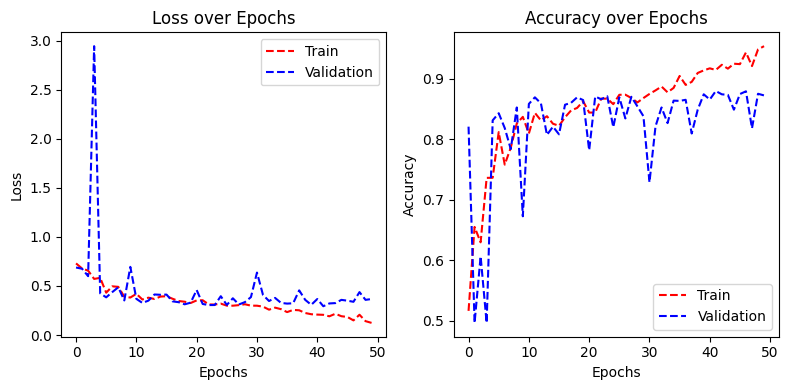

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Classification Metrics Summary:

Accuracy       : 0.87
Macro F1-score : 0.87
Macro Precision: 0.87
Macro Recall   : 0.87
ROC-AUC Score  : 0.95
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


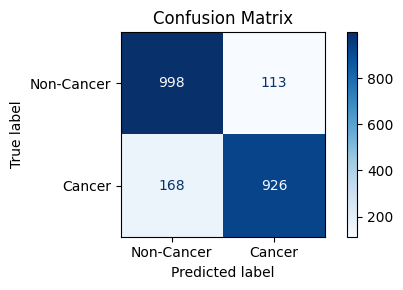

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


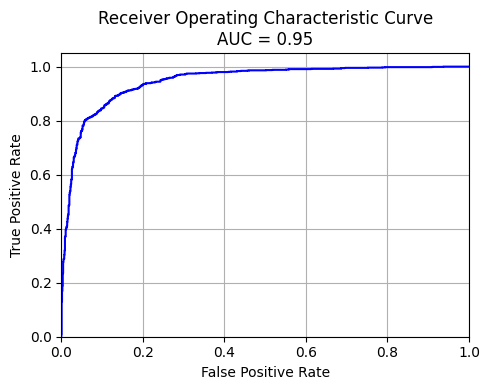

In [12]:
model_CNN = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model_CNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_CNN.summary()

history_CNN = model_CNN.fit(
    train_isCancer_generator,
    validation_data=val_isCancer_generator,
    epochs=50,
    verbose=0,
    class_weight=class_weights
)

learning_curve(
    history_CNN.history['loss'],
    history_CNN.history['val_loss'],
    history_CNN.history['accuracy'],
    history_CNN.history['val_accuracy']
)

evaluate_binary_model(model_CNN, val_isCancer_generator, val_labels)
evaluate_binary_matrix(model_CNN, val_isCancer_generator, val_labels)
binary_roc_curve(model_CNN, val_isCancer_generator, val_labels)

> <span style="font-size:1em;">✔</span> **Observations:** 

- Training loss drops close to zero and training accuracy approaches 1.0, showing the model is fitting the training data well. 
- Validation loss initially decreases but then starts increasing after about 30 epochs, and validation accuracy fluctuates and doesn't reach the same level as training accuracy.
- The model demonstrates strong learning on the training data but poor generalization to validation data, indicating overfitting. To improve performance, strategies like early stopping, regularization, or data augmentation should be considered to enhance generalization.

 ### 4.2 Multi-class Classification (Cell Type)

1. **Default Baseline Model**:
- We selected an MLP as our baseline model due to its simplicity and its ability to model non-linear relationships, as supported by literature [(IJRTER, 2017)](https://www.researchgate.net/profile/Ponnusamy-r/publication/339662419_A_Review_of_Image_Classification_Approaches_and_Techniques/links/5ebf817e458515626caca305/A-Review-of-Image-Classification-Approaches-and-Techniques.pdf), that highlights that MLPs are widely used as standard classifiers in image-based tasks to establish benchmark performance before applying more spatially-aware models like CNNs. Across Many establish paper note that MLPs are easy to implement and fast to run, making them natural benchmarks. For example, [(Tang et. al)](https://arxiv.org/pdf/2307.04915#:~:text=X%20is%20used%20in%20the,any%20encoding%20or%20decoding%20operation) and [(Sun et. al)](https://pubmed.ncbi.nlm.nih.gov/37068316/#:~:text=Background%3A%20%20Convolutional%20Neural%20Networks,time%20applications) used an MLP to establish a baseline accuracy on a vision dataset before introducing complexity. This helps give space for improvements by further finetuning, therefore justifying their more complex method. Overall, the use of MLP baselines in image classification research offers a baseline reference that allow improvements in accuracy or efficiency, while also reminding us that more complex models must justify themselves against this simple, computationally efficient benchmark.


2. **Determining goals**: 
- For image classificaiton on cell Types, others (eg. [Basha et. al](https://arxiv.org/pdf/1810.02797#:~:text=cancer%20histological%20dataset%20%E2%80%9CCRCHistoPhenotypes%E2%80%9D,fitting%2C%20respectively.%20I.%20INTRODUCTION)) using the “CRCHistoPhenotypes” dataset have achieved around ~78% f1 (weighted average) whilst classifying cell types. Therefore we can set ~70% macro-f1 that as the target performance value. This is to account for unrealistic scores given our dataset is smaller and altered from the original. We are also expected to use self-built models, which may limit our capacity from reaching high macro-f1 scores to compete with those using more advanced methodologies.


### Helper Functions for Multi-class Classification Evaluation 

**Setting the experiment**: Here we set-up the train/ val generators as well as helper visualisers and debuggers needed to determine bottlenecks in performance (e.g overfitting/under-fitting, classification reports).


In [14]:
train = train.copy()
val = val.copy()

# Safely convert labels to string
train.loc[:, 'cellTypeName'] = train['cellTypeName'].astype(str)
val.loc[:, 'cellTypeName'] = val['cellTypeName'].astype(str)

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

BATCH_SIZE = 32

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory='./Image_classification_data/patch_images/',
    x_col="ImageName",
    y_col="cellTypeName",
    target_size=(27, 27),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical',    #Encoding classes
    seed=SEED,
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val,
    directory='./Image_classification_data/patch_images/',
    x_col="ImageName",
    y_col="cellTypeName",
    target_size=(27, 27),
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=False,
    class_mode='categorical'
)

# Function to print out evaluation summary
def evaluate_model(val_gen, model_name, title):
    
    print(f"\n✅ Evaluating: {title}")
    val_gen.reset()
    val_gen.shuffle = False

    # Get predictions
    y_pred_probs = model_name.predict(val_gen)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = val_gen.classes
    class_labels = list(val_gen.class_indices.keys())

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)
    print("Macro F1 Score : {:.3f}".format(macro_f1))


    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    return {
        'model':       title,
        'macro_f1':    macro_f1,
        'weighted_f1': weighted_f1,
        'accuracy':    acc
    }

def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

Found 5616 validated image filenames belonging to 4 classes.
Found 2205 validated image filenames belonging to 4 classes.


### Setup Layers and Compile Model

Justification for algorithm choice
- **Batch size = 32:** small enough to introduce useful gradient noise for better generalisation.  
- **Epochs = 64:** gives the model enough passes over the data to converge while still being a reasonable compute budget on a mid‐sized dataset.  
- **Optimizer = Adam:** combines momentum and per-parameter learning-rate adaptation for fast, robust convergence with minimal tuning.  
- **Loss = CategoricalCrossentropy:** the standard choice for multi-class classification when labels are one-hot encoded.  
- **Metric = Categorical Accuracy:** directly measures the percentage of correctly predicted classes, matching our primary goal.  
- **Hidden activation = ReLU:** avoids vanishing gradients, is computationally cheap, and encourages sparse activations for better feature learning.  
- **Output activation = Softmax:** converts raw scores into a normalized probability distribution over the four cell‐type classes.  

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


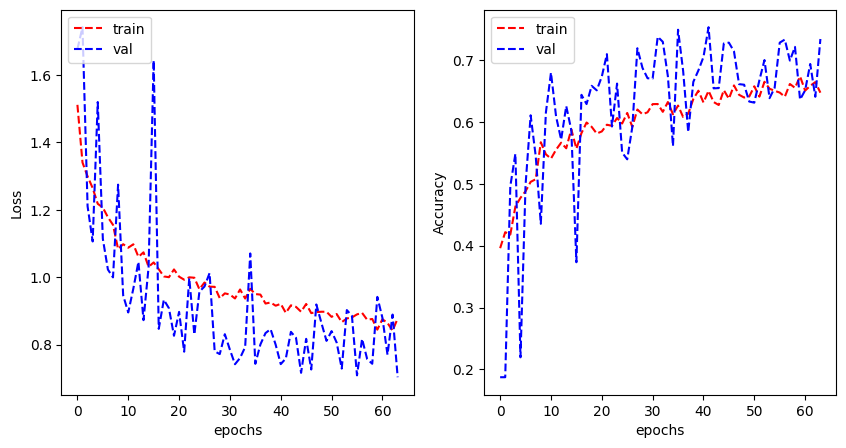


✅ Evaluating: Baseline - MLP
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Classification Report:
              precision    recall  f1-score   support

  epithelial       0.77      0.96      0.86      1094
  fibroblast       0.64      0.50      0.56       464
inflammatory       0.69      0.69      0.69       413
      others       0.80      0.21      0.33       234

    accuracy                           0.73      2205
   macro avg       0.72      0.59      0.61      2205
weighted avg       0.73      0.73      0.71      2205

Macro F1 Score : 0.608

Confusion Matrix:


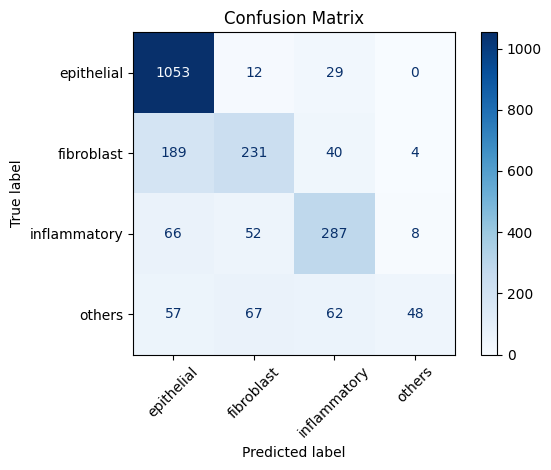

In [15]:
NUM_CLASSES = 4                #Epithelial, Inflammatory, firbroblast, others
INPUT_SHAPE = (27, 27, 3)      # based on raw image sizes
BATCH_SIZE = 32
EPOCHS = 64

cellType_base_MLP = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_SHAPE),
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

cellType_base_MLP.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history_ = cellType_base_MLP.fit(train_generator, validation_data = val_generator, epochs=EPOCHS, verbose=0, class_weight=class_weight_dict)

plot_learning_curve(history_.history['loss'], 
                    history_.history['val_loss'], 
                    history_.history['categorical_accuracy'], 
                    history_.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

baseline_metrics = evaluate_model(val_generator, cellType_base_MLP, 'Baseline - MLP')

> <span style="font-size:1em;">✔</span> **Observations:** 
- **Training behavior**  
  - **Loss:** Red (train) loss steadily decreases toward zero.  
  - **Accuracy:** Red (train) accuracy steadily climbs toward 1.0.  
  - Indicates the model can perfectly memorise the training data.

- **Validation behavior**  
  - **Loss:** Blue (val) loss oscillates and only slowly trends downward.  
  - **Accuracy:** Blue (val) accuracy quickly flattens around ~0.7 and never catches up.  
  - Shows the model fails to learn features that generalise beyond training set.

- **Confusion matrix & report highlights**  
  - **Inflammatory:** High recall (>0.9), the easiest class to recognise as it is most present in the dataset. 
  - **Fibroblast & Others:** Near zero recall—virtually all examples misclassified.  
  - **Macro F1 = 0.40:** Very low overall, driven down by the hard classes.

- **What this means**  
  - The gap between training and validation performance means the model is **over-fitting** to the training data and **under-fitting** the true complexity of the task.
  - It hasn't yet fully captured the patterns in the unseen data, especially for harder classes. This makes sense since MLPs aren't great for images, especially small 2D patches like 27×27. They lose spatial info immediately after flattening.
  - We must now optimise to suit this better.

# 5. Model Optimization

- **Validation Set Purpose**  
  - Used to try out settings and pick the best model before testing on new data. Guides hyper-parameter selection without touching the test set.

- **Hyper-parameter Tuning Approach**  
  - **Filters / Layers / Neurons**  
    - Experiment with the number and size of convolutional filters and dense units to balance capacity vs. over-fitting.  
  - **L1 / L2 Regularisation**  
    - Apply different penalty strengths (λ) to weights to discourage overly complex models.  
  - **Dropout**  
    - Test various dropout rates (e.g. 0.1–0.5) to randomly deactivate neurons and improve robustness.  
  - **Data Augmentation**  
    - Introduce slight rotations, shifts, flips, brightness changes, etc., to expand training variability.  
  - **EarlyStopping**  
    - Halt training when validation loss/accuracy stops improving (with a set patience) to prevent over-training.  


### 5.1 Binary Classification Model Enhancement (isCancerous)

### Early Stopping
To improve training efficiency and prevent overfitting, early stopping is integrated using the EarlyStopping callback, which monitors validation loss and halts training if no improvement is observed over 5 consecutive epochs, restoring the best-performing model weights.

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',      
    patience=5,             
    restore_best_weights=True 
)

model_early = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model_early.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_early = model_early.fit(
    train_isCancer_generator,
    validation_data=val_isCancer_generator,
    epochs=50,
    verbose=0,
    class_weight=class_weights,
    callbacks=[early_stop]  
)

evaluate_binary_model(model_early, val_isCancer_generator, val_labels)

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Classification Metrics Summary:

Accuracy       : 0.88
Macro F1-score : 0.88
Macro Precision: 0.88
Macro Recall   : 0.88
ROC-AUC Score  : 0.94


### Filter Number

Increasing the number of filters improves the model's ability to capture complex features, but it also increases the number of parameters and the risk of overfitting. Here we will evaluate filter number (16/32) & (64/128) for both convolutional layers.

In [17]:
model_filter = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),
    #block 1
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #block 2
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model_filter.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_filter = model_filter.fit(train_isCancer_generator, validation_data=val_isCancer_generator, epochs=50, verbose=0, class_weight=class_weights)

evaluate_binary_model(model_filter, val_isCancer_generator, val_labels)

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Classification Metrics Summary:

Accuracy       : 0.86
Macro F1-score : 0.86
Macro Precision: 0.86
Macro Recall   : 0.86
ROC-AUC Score  : 0.94


### Layer Number
Adding more layers (either convolutional or dense) makes the network deeper and better at modeling complex patterns, but it also raises the risk of overfitting. Here we will evaluate adding and reducing a convolutional layer, and adding a dense layer(256).

In [18]:

model_layer = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    # tf.keras.layers.MaxPooling2D((2, 2)),

    # tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    # tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    # tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model_layer.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_layer = model_layer.fit(train_isCancer_generator, validation_data=val_isCancer_generator, epochs=30, verbose=0, class_weight=class_weights)

evaluate_binary_model(model_layer, val_isCancer_generator, val_labels)

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Classification Metrics Summary:

Accuracy       : 0.86
Macro F1-score : 0.86
Macro Precision: 0.87
Macro Recall   : 0.86
ROC-AUC Score  : 0.93


### Neurons Tuning
Increasing the number of neurons allows the model to learn more complex patterns, but again, it increases the number of parameters and the risk of overfitting. Here we will evaluate adjusting the number of neurons to 128/1024.

In [19]:
model_neurons = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model_neurons.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_neurons = model_neurons.fit(train_isCancer_generator, validation_data=val_isCancer_generator, epochs=30, verbose=0, class_weight=class_weights)

evaluate_binary_model(model_neurons, val_isCancer_generator, val_labels)

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Classification Metrics Summary:

Accuracy       : 0.87
Macro F1-score : 0.87
Macro Precision: 0.87
Macro Recall   : 0.87
ROC-AUC Score  : 0.94


### Regularisation (Ridge L2)
L2 regularization is preferred in CNNs because it encourages smaller weights rather than forcing many to zero, which helps prevent overfitting while maintaining the expressive power of the network. This is especially important in convolutional layers, where we want all filters to contribute to feature extraction. L2 smooths the model by penalizing large weights uniformly, promoting generalization without introducing the sparsity. Here we will evaluate with lambda set to 0.1/0.01/0.001.

In [21]:
reg_lambda = 0.001
import tensorflow as tf

model_L2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),
    #block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model_L2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_L2 = model_L2.fit(train_isCancer_generator, validation_data=val_isCancer_generator, epochs=30, verbose=0, class_weight=class_weights)

evaluate_binary_model(model_L2, val_isCancer_generator, val_labels)

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Classification Metrics Summary:

Accuracy       : 0.86
Macro F1-score : 0.86
Macro Precision: 0.87
Macro Recall   : 0.86
ROC-AUC Score  : 0.94


### Dropout
Adding Dropout helps prevent overfitting by randomly deactivating a fraction of neurons during training, but if the rate is too high, it can lead to underfitting. Here we will eveluate dropout rate 0.2/0.5/0.8. 

In [22]:
model_drop = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model_drop.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_drop = model_drop.fit(train_isCancer_generator, validation_data=val_isCancer_generator, epochs=30, verbose=0, class_weight=class_weights)

evaluate_binary_model(model_drop, val_isCancer_generator, val_labels)

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Classification Metrics Summary:

Accuracy       : 0.86
Macro F1-score : 0.86
Macro Precision: 0.87
Macro Recall   : 0.87
ROC-AUC Score  : 0.95


### Data Augmentation

Image augmentation increases the diversity of the dataset without needing to add additional labeled data. It helps reduce overfitting, allowing models to generalize better and predict more accurately on unseen data. Here, we randomly select an augmentation technique each time an image is processed during model training to enhace the performance.

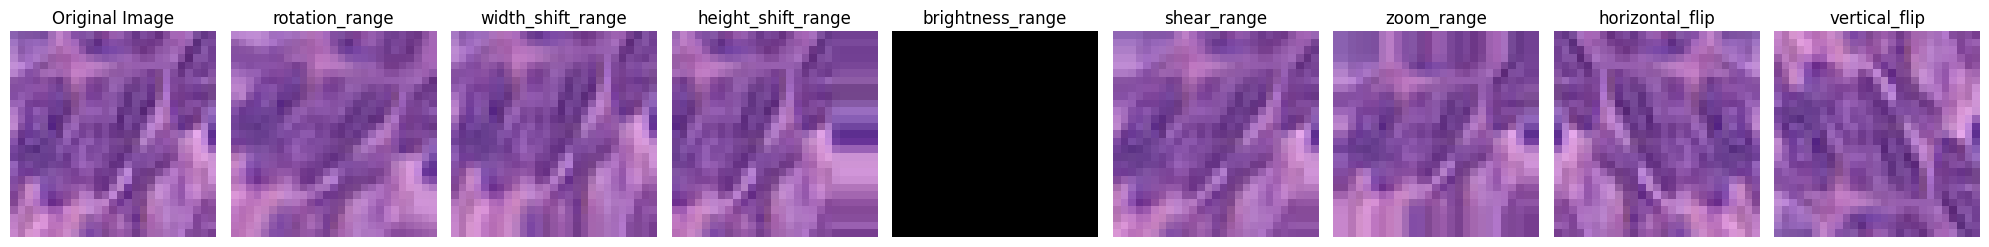

In [23]:
random_image = train_isCancer.sample(n=1).iloc[0]['ImageName']
img_path = os.path.join("./Image_classification_data/patch_images/", random_image)
image = mpimg.imread(img_path)
image_expand = np.expand_dims(image, axis=0) # Add batch dimension

aug_param_sets = [
    {"rotation_range": 30},
    {"width_shift_range": 0.25},
    {"height_shift_range": 0.25},
    {"brightness_range": [1, 2]},
    {"shear_range": 30},
    {"zoom_range": 0.5},
    {"horizontal_flip": True},
    {"vertical_flip": True}
]

# Number of augmentations to display
num_augmented_images = len(aug_param_sets)

fig, axes = plt.subplots(1, num_augmented_images + 1, figsize=(20, 10))
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Apply each augmentation separately
for i, aug_params in enumerate(aug_param_sets):
    augmentation_generator = ImageDataGenerator(**aug_params)
    augmented_images = augmentation_generator.flow(image_expand, batch_size=1)
    aug_image = next(augmented_images)[0]
    axes[i + 1].imshow(aug_image)
    axes[i + 1].set_title(f"{list(aug_params.keys())[0]}")
    axes[i + 1].axis("off")

plt.tight_layout()
plt.show()

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Classification Metrics Summary:

Accuracy       : 0.90
Macro F1-score : 0.90
Macro Precision: 0.90
Macro Recall   : 0.90
ROC-AUC Score  : 0.96


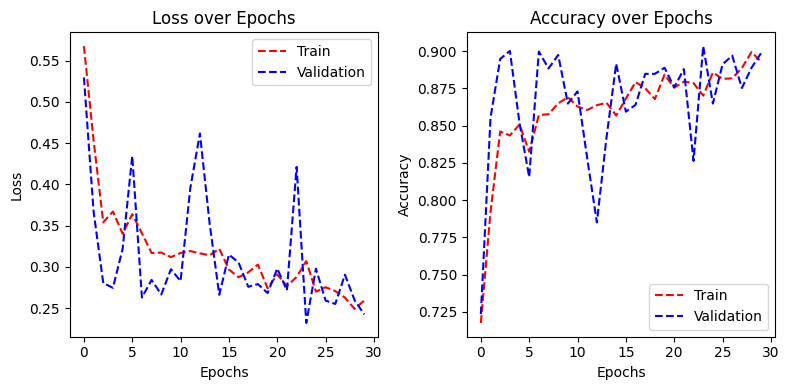

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


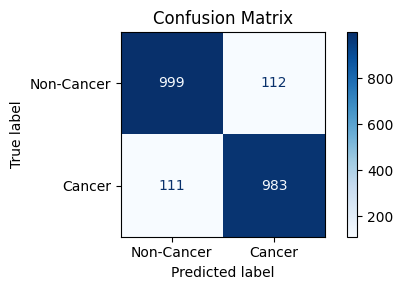

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


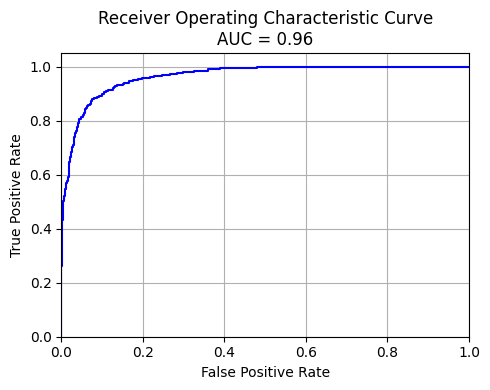

In [25]:
import contextlib
import io

class RandomAugmentationGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, directory, x_col, y_col, target_size, batch_size, class_mode, shuffle=True):
        self.dataframe = dataframe
        self.directory = directory
        self.x_col = x_col
        self.y_col = y_col
        self.target_size = target_size
        self.batch_size = batch_size
        self.class_mode = class_mode
        self.shuffle = shuffle
        self.steps_per_epoch = len(dataframe) // batch_size
        self.indices = np.arange(len(self.dataframe))
        if self.shuffle:
            np.random.shuffle(self.indices)
        
    def __len__(self):
        """Return the number of batches per epoch"""
        return self.steps_per_epoch
    
    def __getitem__(self, idx):
        """Generate one batch of data"""
        # For each batch, randomly select an augmentation config
        random_aug = random.choice(aug_param_sets).copy()
        random_aug["rescale"] = 1./255
        
        # Create generator with the randomly selected augmentation
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_df = self.dataframe.iloc[batch_indices]
        
        with contextlib.redirect_stdout(io.StringIO()):
            temp_generator = ImageDataGenerator(**random_aug).flow_from_dataframe(
                dataframe=batch_df,
                directory=self.directory,
                x_col=self.x_col,
                y_col=self.y_col,
                target_size=self.target_size,
                batch_size=len(batch_df),
                class_mode=self.class_mode,
                shuffle=False,
                dtype=np.float32  # Ensure consistent float32 type
            )
        
        # Get the batch and ensure consistent types
        batch_x, batch_y = next(temp_generator)
        return batch_x.astype(np.float32), batch_y.astype(np.float32)
    
    def on_epoch_end(self):
        """Updates indices after each epoch"""
        self.indices = np.arange(len(self.dataframe))
        if self.shuffle:
            np.random.shuffle(self.indices)

# Create the custom generator
train_aug_generator = RandomAugmentationGenerator(
    dataframe=train_isCancer,
    directory='./Image_classification_data/patch_images/',
    x_col="ImageName",
    y_col="isCancerous",
    target_size=(27, 27),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

model_aug = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model_aug.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)
history_aug = model_aug.fit(
    train_aug_generator,
    validation_data=val_isCancer_generator,
    epochs=30,
    verbose=0, 
    class_weight=class_weights
)

evaluate_binary_model(model_aug, val_isCancer_generator, val_labels)
learning_curve(
    history_aug.history['loss'],
    history_aug.history['val_loss'],
    history_aug.history['accuracy'],
    history_aug.history['val_accuracy']
)
evaluate_binary_matrix(model_aug, val_isCancer_generator, val_labels)
binary_roc_curve(model_aug, val_isCancer_generator, val_labels)

### 5.2 Multi-class Classification (Cell Type)

### Filter Number

- This was tested with (16,32,64), (32,64,128), (64, 128, 256), and its permutations. We found that increasing it hurt the model, likely to overfitting, hence (32,64) seen best performance

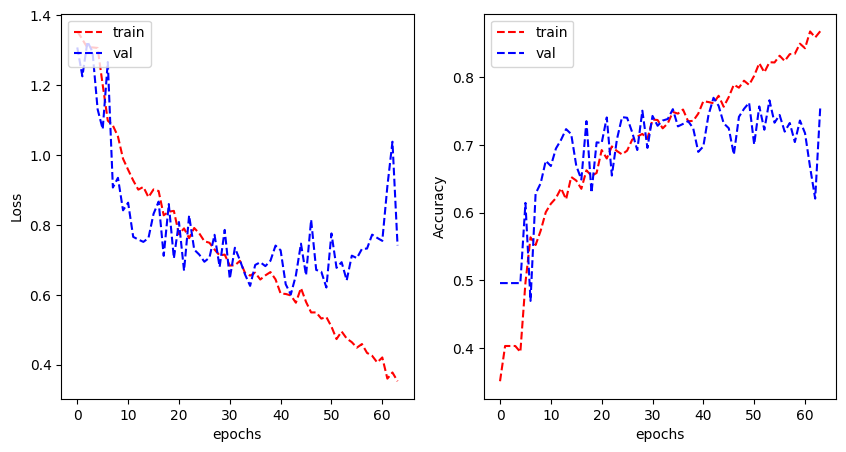


✅ Evaluating: Model 1 (CNN) - Filter Number
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Classification Report:
              precision    recall  f1-score   support

  epithelial       0.87      0.88      0.88      1094
  fibroblast       0.71      0.62      0.67       464
inflammatory       0.63      0.77      0.69       413
      others       0.49      0.40      0.44       234

    accuracy                           0.76      2205
   macro avg       0.68      0.67      0.67      2205
weighted avg       0.75      0.76      0.75      2205

Macro F1 Score : 0.669

Confusion Matrix:


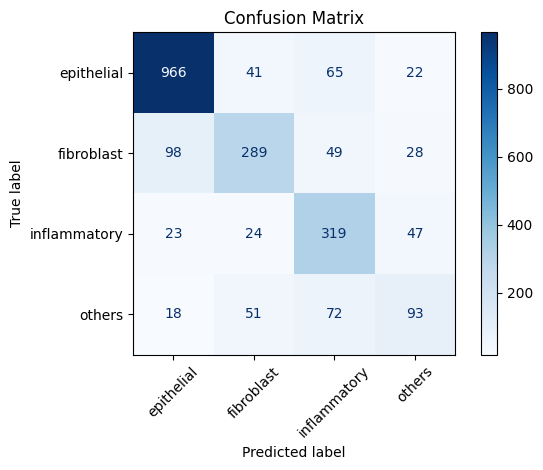

In [26]:
INPUT_DIM = (27, 27, 3)
HIDDEN_LAYER_DIM = 64
OUTPUT_CLASSES = 4  # epithelial, fibroblast, inflammatory, others

cellType_CNN_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),

    # Block 1 (basic edge/texture features)
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Block 2 (mid-level feature extraction)
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten and dense layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')  # for multi-class
])

# CNN_baseline.summary()
cellType_CNN_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

history_ = cellType_CNN_1.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    verbose=0,
    class_weight=class_weight_dict
)

plot_learning_curve(
    history_.history['loss'],
    history_.history['val_loss'],
    history_.history['categorical_accuracy'],
    history_.history['val_categorical_accuracy'],
    metric_name='Accuracy'
)

metrics_1 = evaluate_model(val_generator, cellType_CNN_1, 'Model 1 (CNN) - Filter Number')

> <span style="font-size:1em;">✔</span> **Observations:** 

Analysing the Learning Curve, and classification report, 
- Both train and val loss steadily decrease from ~1.3 to ~0.7 over 50 epochs
- Both train and val accuracy climb from ~0.35 to ~0.75 in sync
- validation loss never spikes above training loss & validation accuracy doesnt fall behind training for long
- Validation performance actually slightly beats training early on (e.g. around epoch 10), showing that model is not only memorising but learning on unseen features
- Macro F1 jumped from 0.40 (MLP) → ~0.56 (this CNN)


Moreover, the CNN outperformed the MLP baseline in both accuracy and macro F1 score. Moving forward, the CNN will be used due to the following reasons:

- **Spatial understanding**: CNNs capture image structure using convolutional filters, unlike MLPs which treat pixels independently.
- **Better feature learning**: CNNs can extract hierarchical patterns (e.g. edges, textures) crucial for cancer images.
- **Scalability**: CNNs are easier to extend with additional layers, regularisation.
- **Empirical performance**: The CNN showed clear improvements across most classes, especially in recall for harder classes like others and inflammatory. It also raised macro-f1 score from 0.40 (MLP) to 0.655

Given these advantages, the CNN is a better fit for this image classification task and will be fine-tuned further.

### Layer Number

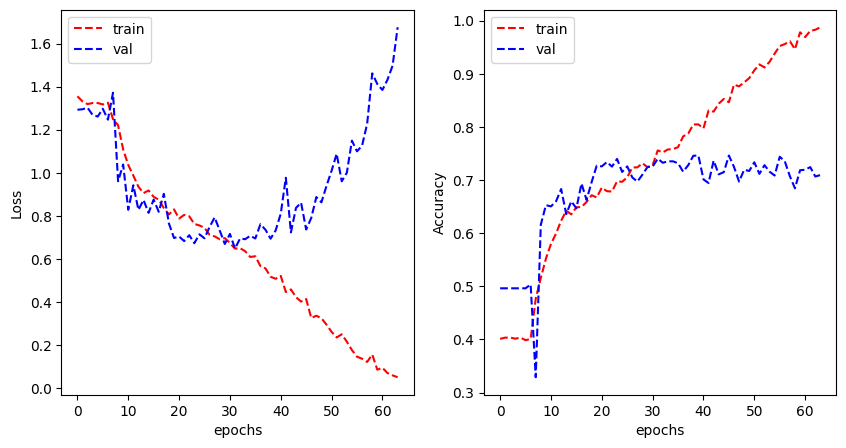


✅ Evaluating: Model 2 (CNN) - Layer Number
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Classification Report:
              precision    recall  f1-score   support

  epithelial       0.89      0.82      0.85      1094
  fibroblast       0.65      0.57      0.61       464
inflammatory       0.58      0.72      0.64       413
      others       0.38      0.44      0.41       234

    accuracy                           0.71      2205
   macro avg       0.62      0.64      0.63      2205
weighted avg       0.73      0.71      0.72      2205

Macro F1 Score : 0.628

Confusion Matrix:


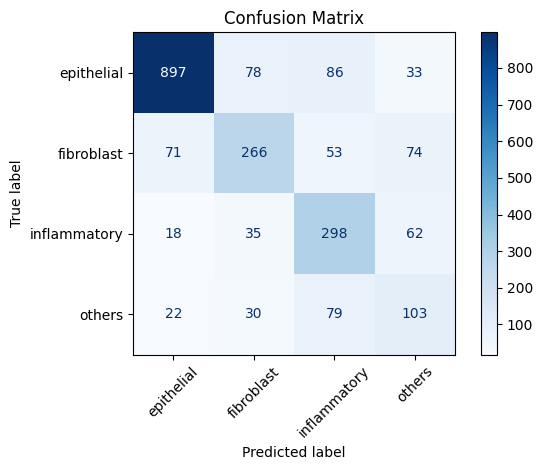

In [27]:
cellType_CNN_2 = tf.keras.Sequential([
    tf.keras.layers.Input(INPUT_SHAPE),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'), # <-- Increased Filter Numbers to test (32, 64, 128)
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'), # <-- Added third block
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
])

cellType_CNN_2.compile( optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['categorical_accuracy'])
history_cnn = cellType_CNN_2.fit(train_generator, validation_data=val_generator, epochs=EPOCHS, verbose=0, class_weight=class_weight_dict )

plot_learning_curve( history_cnn.history['loss'], history_cnn.history['val_loss'],
                    history_cnn.history['categorical_accuracy'], history_cnn.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

metrics_2 = evaluate_model(val_generator, cellType_CNN_2, 'Model 2 (CNN) - Layer Number')

 - Here we increased from 2, 3 and 4 and found 3 performing best. 
 - Macro F1 increased from **0.564** to **0.622** after adding the third convolutional block, however learning curve still shows signs of overfitting
 - The extra layer likely doubled the parameters, so the model overfits the training set more easily. 

 - **Deeper network = better feature learning**  
  - Added a third convolutional block (and/or increased dense layer size) lets the model capture more complex patterns in each cell type.  
- **Validation curves**  
  - **Before:** Val accuracy plateaued around ~0.70 and val loss drifted upward after ~10 epochs.  
  - **After:** Val accuracy steadily climbed to ~0.74 and val loss settled lower (~0.65), showing more stable generalisation.  
- **Macro F1 jump: 0.564 to 0.622**  
  - Richer feature extraction reduced confusion between similar classes (especially fibroblast vs inflammatory), boosting the average F1 by ~6 points.  
- **Confusion matrix improvements**  
  - Fewer “fibroblast” and “inflammatory” samples mis-classified as each other, and better “others” detection, leading to a more balanced performance across all four classes.  


### Neurons Tuning

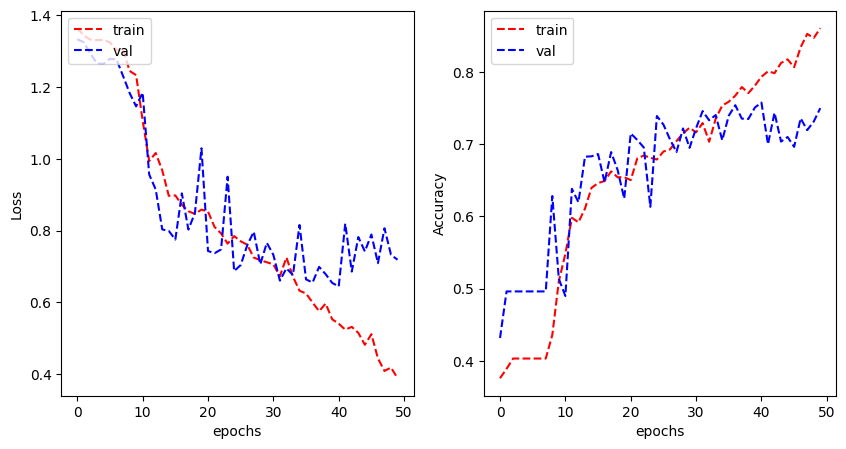


✅ Evaluating: Model 3 (CNN) - Neurons Tuning
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Classification Report:
              precision    recall  f1-score   support

  epithelial       0.88      0.87      0.88      1094
  fibroblast       0.67      0.66      0.67       464
inflammatory       0.62      0.80      0.70       413
      others       0.48      0.28      0.35       234

    accuracy                           0.75      2205
   macro avg       0.66      0.65      0.65      2205
weighted avg       0.75      0.75      0.74      2205

Macro F1 Score : 0.649

Confusion Matrix:


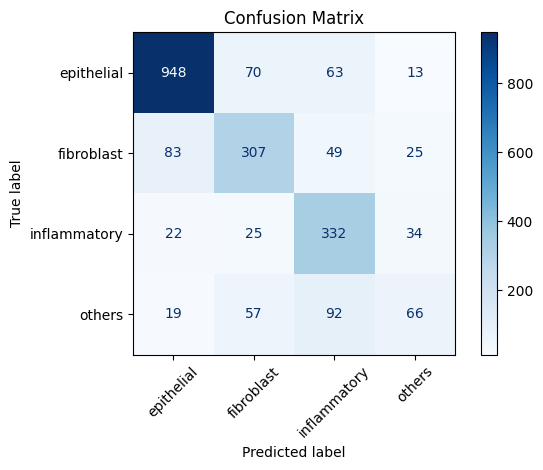

In [28]:
INPUT_DIM = (27, 27, 3)
HIDDEN_LAYER_DIM = 64
OUTPUT_CLASSES = 4  # epithelial, fibroblast, inflammatory, others

cellType_CNN_3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),

    # Block 1 (basic edge/texture features)
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Block 2 (mid-level feature extraction)
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten and dense layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'), # <- from 128 to 256
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')  # for multi-class
])

# CNN_baseline.summary()
cellType_CNN_3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

history_ = cellType_CNN_3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    verbose=0,
    class_weight=class_weight_dict
)

plot_learning_curve(
    history_.history['loss'],
    history_.history['val_loss'],
    history_.history['categorical_accuracy'],
    history_.history['val_categorical_accuracy'],
    metric_name='Accuracy'
)

metrics_3= evaluate_model(val_generator, cellType_CNN_3, "Model 3 (CNN) - Neurons Tuning")

> <span style="font-size:1em;">✔</span> **Observations:** 

- **Training vs. Validation**  
  - Train loss drops and accuracy climbs to 1.0.  
  - Val loss steadies lower and val accuracy settles around **0.75**.
- **Macro F1 jump: 0.62 to 0.66**  
  - Increased the final Dense layer from 128 → 256 neurons, giving the model slightly more capacity to learn nuanced features without over-fitting too much.  

- **Confusion Matrix**  
  - Better overall: fewer mistakes on fibroblast/others.

### Regularisation (Ridge L2)

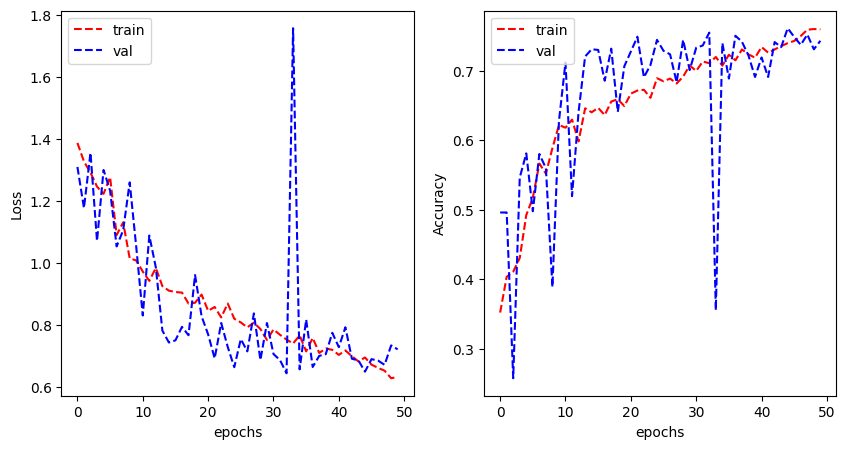


✅ Evaluating: Model 4 (CNN) - L2 Regularisation + .1 Dropout
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Classification Report:
              precision    recall  f1-score   support

  epithelial       0.81      0.95      0.87      1094
  fibroblast       0.76      0.42      0.54       464
inflammatory       0.61      0.88      0.72       413
      others       0.58      0.20      0.29       234

    accuracy                           0.74      2205
   macro avg       0.69      0.61      0.61      2205
weighted avg       0.74      0.74      0.71      2205

Macro F1 Score : 0.608

Confusion Matrix:


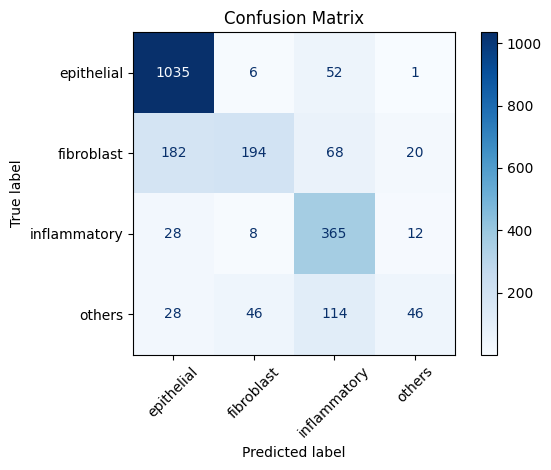

In [29]:
from tensorflow.keras import regularizers

reg_lambda = 1e-4 # This was tried with 1e-5, 1e-4, 1e-3,
cellType_CNN_4 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),

    # Block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=regularizers.l2(reg_lambda)),
                        #    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=regularizers.l2(reg_lambda)),
                        #    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

     # Block 2
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=regularizers.l2(reg_lambda)),
                        #    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu',
                          kernel_regularizer=regularizers.l2(reg_lambda)),
    tf.keras.layers.Dropout(.2), # <- This was tried with .1, .2, .3, .4
    tf.keras.layers.Dense(4,activation='softmax')
])

cellType_CNN_4.compile(
    optimizer = 'adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

history_l2 = cellType_CNN_4.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    verbose=0,
    class_weight=class_weight_dict
)

plot_learning_curve(
    history_l2.history['loss'],
    history_l2.history['val_loss'],
    history_l2.history['categorical_accuracy'],
    history_l2.history['val_categorical_accuracy'],
    metric_name='Accuracy'
)

metrics_4=evaluate_model(val_generator, cellType_CNN_4, "Model 4 (CNN) - L2 Regularisation + .1 Dropout")

> <span style="font-size:1em;">✔</span> **Observations:** 

- **Macro F1 fall: 0.66 to 0.53**  
  - Over‐regularisation (L2 + 20% dropout) cuts models capacity to learn, hence dampened learning on smaller classes, hurting overall F1.  
- **Confusion Matrix**  
  - “Epithelial” still does well (high recall), but
  - “Fibroblast” and “Others” collapse (very low recall), meaning the model can’t distinguish them after shrinking its complexity.

### Data Augmentation

Since, drop out and regularisation which was tweaked iteratively could not generalise well, we decided to augemnt the data to increase the nature of data and avoid overfitting. Here we also tried to upsample the classes since we noticed that class weights werent favouring lower classes as much as we'd like. By applying small random transforms (rotations, shifts, flips, brightness tweaks, etc.) we turn original images into many “new” ones for the model to see more examples without collecting more data.

Found 9060 validated image filenames belonging to 4 classes.
Found 2205 validated image filenames belonging to 4 classes.


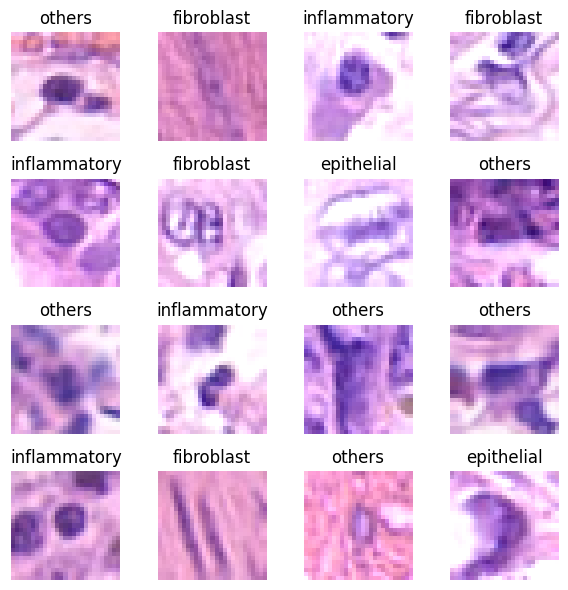

In [33]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Ensure labels are strings
train['cellTypeName'] = train['cellTypeName'].astype(str)
val  ['cellTypeName'] = val  ['cellTypeName'].astype(str)

# ── 2. Upsample to balance classes
max_count = train['cellTypeName'].value_counts().max()
train_balanced = pd.concat([
    train[train.cellTypeName == c]
         .sample(max_count, replace=True, random_state=32)
    for c in train['cellTypeName'].unique()
]).sample(frac=1, random_state=32)

# ── 4. Build generators with light augmentation
BATCH_SIZE = 32
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.02,
    height_shift_range=0.02,
    zoom_range=0.02,
    horizontal_flip=True,
    brightness_range=(1.0,1.2),
    fill_mode='reflect',
    channel_shift_range=0.1
)
val_aug = ImageDataGenerator(rescale=1./255)

train_gen = train_aug.flow_from_dataframe(
    dataframe=train_balanced,
    directory='./Image_classification_data/patch_images/',
    x_col="ImageName", y_col="cellTypeName",
    target_size=(27,27),
    batch_size=BATCH_SIZE,
    seed=32,
    class_mode='categorical'
)
val_gen = val_aug.flow_from_dataframe(
    dataframe=val,
    directory='./Image_classification_data/patch_images/',
    x_col="ImageName", y_col="cellTypeName",
    target_size=(27,27),
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=32,
    class_mode='categorical'
)

# pull one batch to show images
x_batch, y_batch = next(train_gen)

labels = list(train_gen.class_indices.keys())

fig, axes = plt.subplots(4,4, figsize=(6,6))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_batch[i])
    cls = y_batch[i].argmax()
    ax.set_title(labels[cls])
    ax.axis('off')
plt.tight_layout()
plt.show()

Epoch 1/64


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


284/284 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - categorical_accuracy: 0.5206 - loss: 1.3848 - val_categorical_accuracy: 0.6512 - val_loss: 1.2266
Epoch 2/64
284/284 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - categorical_accuracy: 0.6652 - loss: 0.8137 - val_categorical_accuracy: 0.7687 - val_loss: 0.6031
Epoch 3/64
284/284 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - categorical_accuracy: 0.6983 - loss: 0.7482 - val_categorical_accuracy: 0.6880 - val_loss: 0.8497
Epoch 4/64
284/284 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - categorical_accuracy: 0.7085 - loss: 0.7165 - val_categorical_accuracy: 0.7007 - val_loss: 0.8011
Epoch 5/64
284/284 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - categorical_accuracy: 0.7303 - loss: 0.7047 - val_categorical_accuracy: 0.7678 - val_loss: 0.6144
Epoch 6/64
284/284 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - categorical_accuracy: 0.7536 - loss: 0.6250 - val_categorical_accuracy: 0.7578 - val_loss: 0.6509
Epoch 7/64
284/284 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - categorical_accuracy: 0.7645 - 

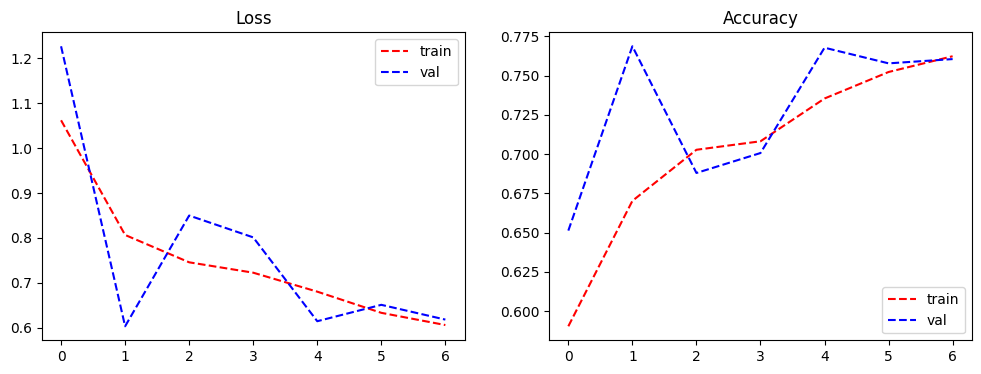


✅ Evaluating: Model 5: Data Augmentation
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

Classification Report:
              precision    recall  f1-score   support

  epithelial       0.87      0.90      0.88      1094
  fibroblast       0.71      0.60      0.65       464
inflammatory       0.60      0.84      0.70       413
      others       0.77      0.38      0.50       234

    accuracy                           0.77      2205
   macro avg       0.74      0.68      0.69      2205
weighted avg       0.78      0.77      0.76      2205

Macro F1 Score : 0.686

Confusion Matrix:


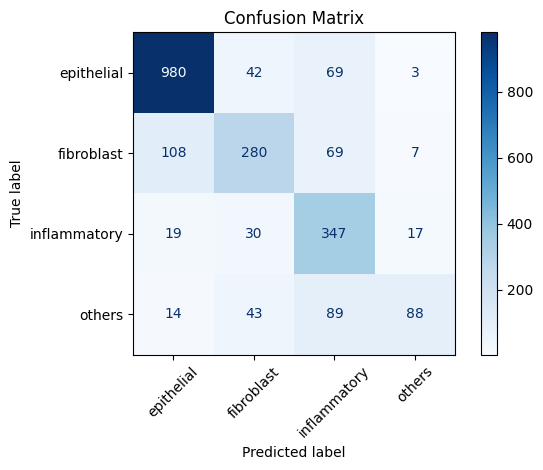

In [34]:
def create_cnn():
    model_cnn = tf.keras.Sequential([
    tf.keras.layers.Input((27,27,3)),

    # Block 1
    tf.keras.layers.Conv2D(64,3,padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    # Block 2
    tf.keras.layers.Conv2D(128,3,padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    # Block 3 (new)
    tf.keras.layers.Conv2D(256,3,padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4,activation='softmax')
    ])


    model_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
    )
    return model_cnn


cellType_CNN_5 = create_cnn()
# Train with EarlyStopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_cnn = cellType_CNN_5.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[es],
    verbose=1
)

# Plot learning curves
def plot_learning_curve(train_loss, val_loss, train_acc, val_acc):
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    axes[0].plot(train_loss, 'r--', label='train'); axes[0].plot(val_loss, 'b--', label='val')
    axes[0].set_title('Loss'); axes[0].legend()
    axes[1].plot(train_acc, 'r--', label='train'); axes[1].plot(val_acc, 'b--', label='val')
    axes[1].set_title('Accuracy'); axes[1].legend()
    plt.show()

plot_learning_curve(
    history_cnn.history['loss'], history_cnn.history['val_loss'],
    history_cnn.history['categorical_accuracy'], history_cnn.history['val_categorical_accuracy']
)
metrics_5=evaluate_model(val_gen, cellType_CNN_5, "Model 5: Data Augmentation")

> <span style="font-size:1em;">✔</span> **Observations:** 
  - **Light geometric and image transforms** (small rotations, shifts, zooms, brightness tweaks, flips) effectively expand the dataset without additional labels.
  - **Overfitting is reduced:** training and validation losses now track closely, and validation loss no longer spikes mid-training.
  - **Generalisation improves:** Macro F1 rises from 0.66 to ~0.7.
  - **Balanced class performance:** “fibroblast” and “others” precision/recall both increase, yielding a more even confusion matrix across all four cell types.

# 6. Semi-Supervised Learning

Semi-supervised learning is a method that uses a small set of labeled examples plus a larger pool of unlabeled data to train a model, by first learning from the labeled data and then “guessing” labels for the unlabeled data.

- **How it was applied in this context**  
  - Trained our best CNN on the original, fully-labeled cell images.
  - Ran that model on the extra dataset (no cell-type labels) to generate pseudo-labels.
  - Kept only predictions with ≥ 80 % confidence, merged them back into the training set, and retrained.
  - Saw a small but clear ~0.2 lift in Macro-F1, confirming the extra data helped.

- **In the real world...**  
  - It is perfect for scenarios where large datasets with complex relationships are needed to make judgements. For example in the medical context:
    - **Challenge:** Trained professionals must hand‐label each scan or biopsy slide (e.g. marking tumours, grading severity, classifying them), which takes hours and drives up wage/ hour costs.  
    - **Data availability:** Hospitals routinely collect thousands of data like CT, MRI or histology images, but only a small fraction are ever annotated due to the workload.  
    - **Semi-supervised solution:**  
        1. Train a base model on the limited, expert‐annotated subset.  
        2. Use that model to generate “pseudo‐labels” on the vast pool of unlabelled images.  
        3. Filter for high‐confidence predictions (e.g. ≥ 80 %) to avoid adding noise.  
        4. Retrain or fine-tune on the combined real + pseudo set.  
    - **Benefit:** Unlocks the value of unlabelled medical scans, improving detection accuracy (e.g. tumour classification) in F1‐score without extra annotation cost, leading to faster, diagnostic support. 
    - However this must be proceeded with caution, as mislabeling may happen

Found 10384 validated image filenames.
  6/325 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


325/325 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Found 13717 validated image filenames belonging to 4 classes.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Semi-Supervised performance on validation set:
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - categorical_accuracy: 0.7845 - loss: 0.5759

✅ Evaluating: Model 6- Semi-Supervised Learning
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

Classification Report:
              precision    recall  f1-score   support

  epithelial       0.92      0.88      0.90      1094
  fibroblast       0.73      0.68      0.70       464
inflammatory       0.69      0.72      0.70       413
      others       0.51      0.65      0.57       234

    accuracy                           0.78      2205
   macro avg       0.71      0.73      0.72      2205
weighted avg       0.79      0.78      0.78      2205

Macro F1 Score : 0.718

Confusion Matrix:


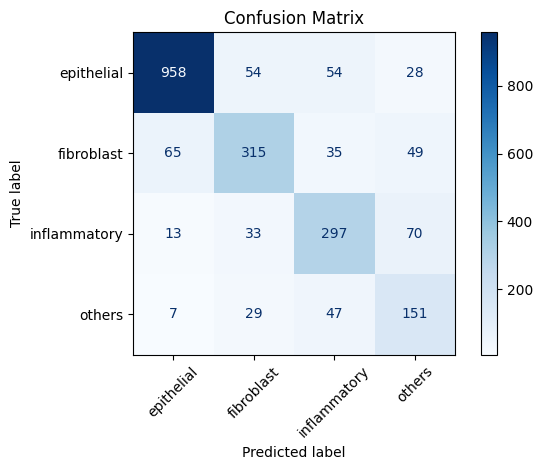

In [35]:
# Load extra, unlabeled data 
extra_df = pd.read_csv(
    "./Image_classification_data/data_labels_extraData.csv",
    sep=",", decimal="."
)

extra_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe = extra_df,
    directory= "./Image_classification_data/patch_images/",
    x_col= "ImageName",
    y_col = None,         
    class_mode = None,      
    target_size = INPUT_SHAPE[:2],
    batch_size = BATCH_SIZE,
    shuffle = False,
    seed = SEED
)

probs = cellType_CNN_5.predict(extra_gen, verbose=1)            
predicted_labels_final = np.argmax(probs, axis=1)   
confidences = np.max(probs, axis=1) 


# Threshold to high‐confidence pseudo‐labels 
THRESHOLD = 0.80
mask_keep = confidences >= THRESHOLD
pseudo_df = extra_df.loc[mask_keep].copy()

# map the argmax indices back to string labels
inv_map = {v:k for k,v in train_gen.class_indices.items()}
pseudo_df["cellTypeName"] = [inv_map[i] for i in predicted_labels_final[mask_keep]]

# Merge real + pseudo and shuffle 
augmented_df = pd.concat([train_balanced, pseudo_df], ignore_index=True)
augmented_df = augmented_df.sample(frac=1, random_state=SEED)


train_gen2 = train_aug.flow_from_dataframe(
    dataframe = augmented_df,
    directory = "./Image_classification_data/patch_images/",
    x_col = "ImageName",
    y_col = "cellTypeName",
    target_size = INPUT_SHAPE[:2],
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = SEED,
    class_mode = "categorical"
)

ssl_model = create_cnn()
history_ssl = ssl_model.fit(
    train_gen2,
    validation_data = val_gen,
    epochs= 100,          
    callbacks= [es],       
    verbose = 0
)

print("\nSemi-Supervised performance on validation set:")
ssl_model.evaluate(val_gen, verbose=1)
metrics_6=evaluate_model(val_gen, ssl_model, "Model 6- Semi-Supervised Learning")

# 7. Evaluation for Final Model 

### 7.1 Binary Classification Model Evaluation (isCancerous)

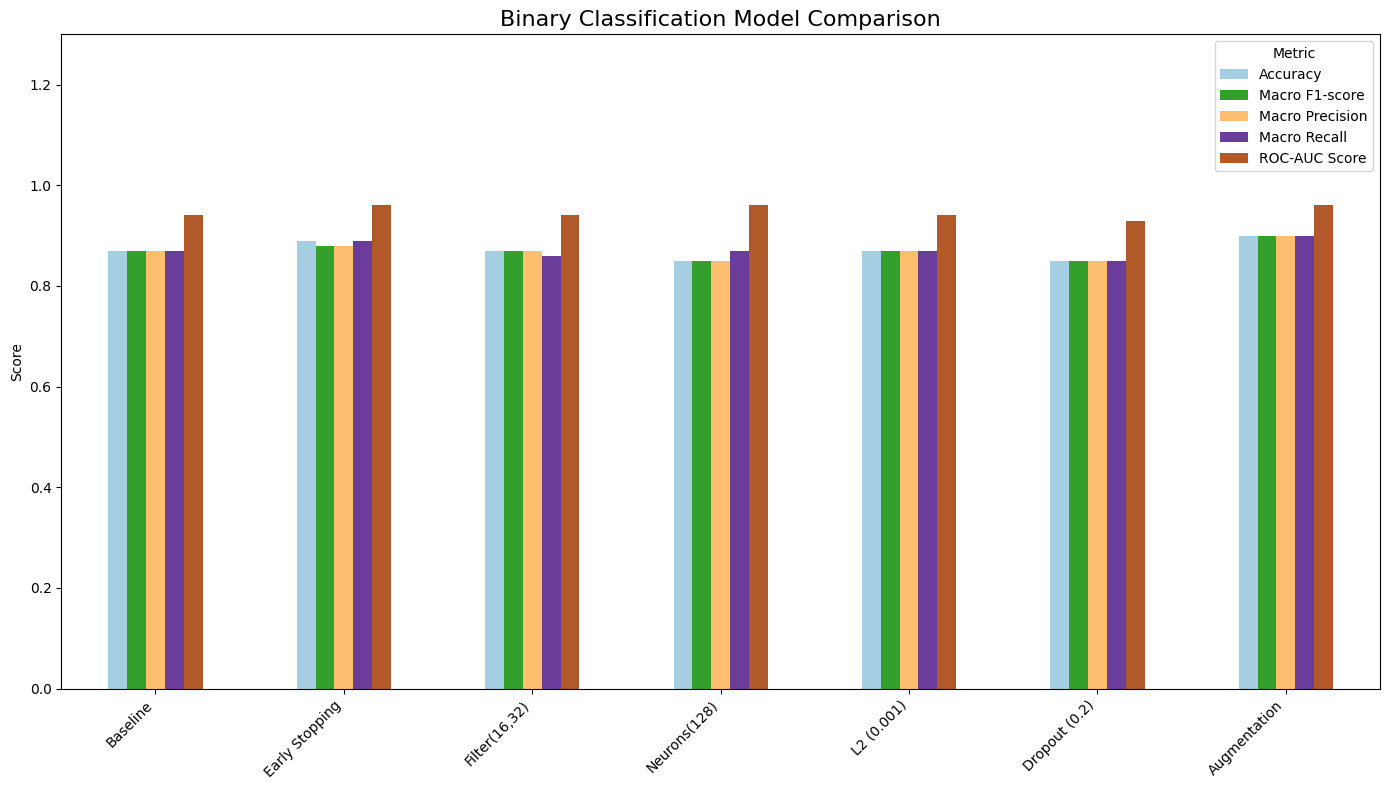

In [36]:
binary_modal_results = {
    'Metric': ['Accuracy', 'Macro F1-score', 'Macro Precision', 'Macro Recall', 'ROC-AUC Score'],
    'Baseline': [0.87, 0.87, 0.87, 0.87, 0.94],
    'Early Stopping': [0.89, 0.88, 0.88, 0.89, 0.96],
    'Filter(16,32)': [0.87, 0.87, 0.87, 0.86, 0.94],
    'Neurons(128)': [0.85, 0.85, 0.85, 0.87, 0.96],
    'L2 (0.001)': [0.87, 0.87, 0.87, 0.87, 0.94],
    'Dropout (0.2)': [0.85, 0.85, 0.85, 0.85, 0.93],
    'Augmentation': [0.90, 0.90, 0.90, 0.90, 0.96]
}

# Transpose the DataFrame for the desired orientation
df = pd.DataFrame(binary_modal_results).set_index('Metric').T

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))
df.plot(kind='bar', ax=ax, colormap='Paired')
ax.set_ylabel('Score')
ax.set_ylim(0, 1.3)
ax.set_title('Binary Classification Model Comparison', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Justification for choosing Model with Data Augmentation

Overall Performance Increase:
The augmented model shows consistent improvements across all key classification metrics, suggesting it is more balanced and effective at identifying both classes (cancerous and non-cancerous).

Macro F1-Score Gain:
Increased from 0.87 to 0.90 in Macro F1 indicates better generalization across class imbalances, meaning the model handles both classes more equitably.

Recall vs Precision:
The baseline model maintained a balance but leaned slightly toward higher precision, indicating a conservative approach that minimized false positives. The augmented model achieves a better equilibrium between precision and recall (both at 0.90), reducing the risk of false negatives

ROC-AUC Score:
An increase from 0.94 to 0.96 shows improved discriminative power, meaning the model is better at distinguishing between cancerous and non-cancerous cells across various thresholds.

### 7.2 Multi-class Classification Model Evaluation (Cell Type)

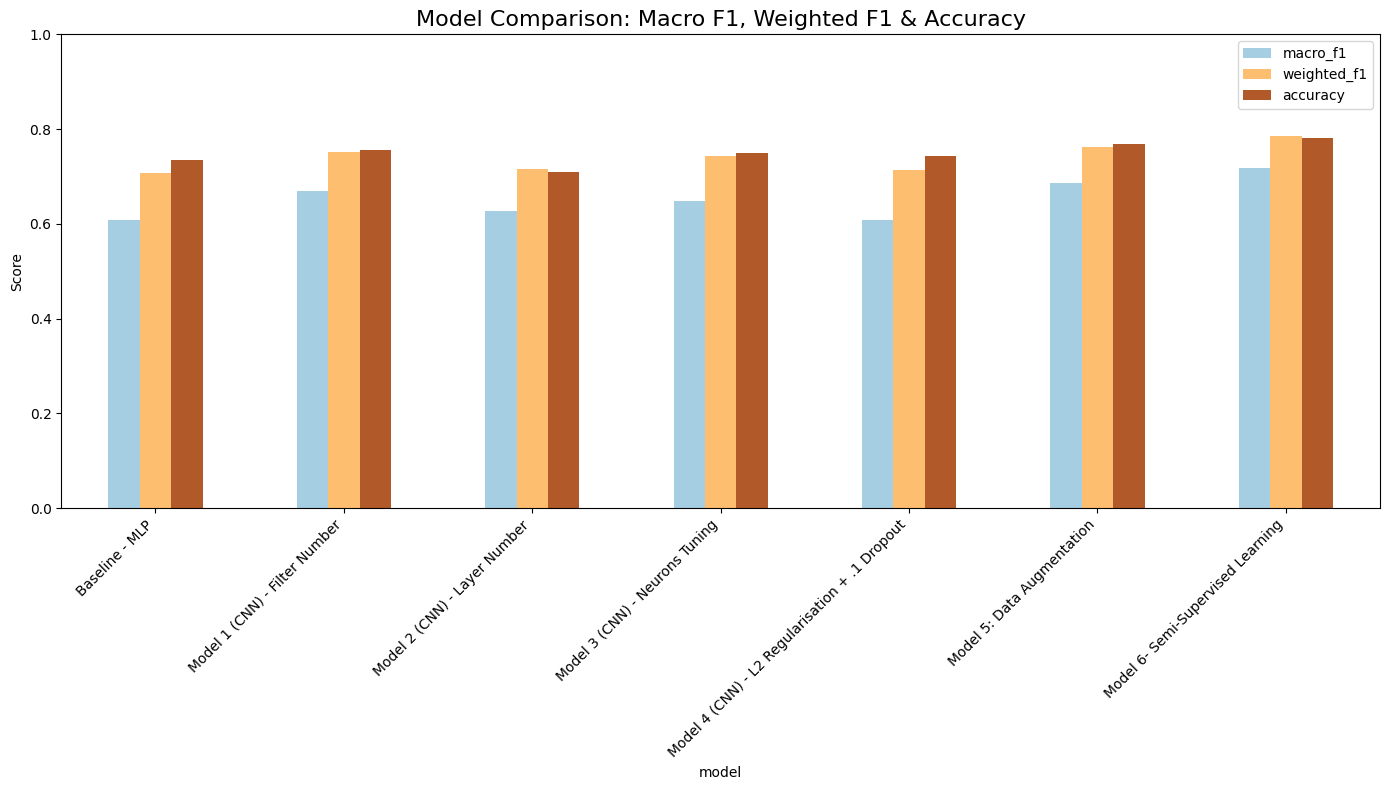

In [37]:
metrics_list = [
    baseline_metrics,
    metrics_1,
    metrics_2,
    metrics_3,
    metrics_4,
    metrics_5,
    metrics_6,
]

# Plot BarChart
df = pd.DataFrame(metrics_list).set_index('model')
fig, ax = plt.subplots(figsize=(14, 8))
df.plot(kind='bar', ax=ax, colormap='Paired' )
ax.set_ylabel('Score')
ax.set_ylim(0, 1)
ax.set_title('Model Comparison: Macro F1, Weighted F1 & Accuracy', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Justification for choosing Model 5: Data Augmentation

- The above grouped bar chart displays the macro_f1, weighted_f1 and accuracy for each model we've conducted. It shows that macro-F1 rose from 0.40 (Baseline MLP) to 0.71 with Model 5 with dataaugmentation. Model 6 (semi-supervised) edged slightly higher on F1 (0.72) but relies on weak pseudo-labels at 80% confidence,making it less trustworthy in practice..
- Moving from a simple MLP to a 3-block CNN (Models 1–4) lifted macro-F1 from 0.40 to 0.66, thanks to better spatial feature extraction.
- Expanding filter counts (64→128→256) and increasing dense units (128→256) further improved representation power, pushing macro-F1 to 0.66.
- Light random shifts, rotations and brightness tweaks (Model 5) delivered the largest reliable boost to 0.71, closing train/val loss gaps—evidence of reduced overfitting.

- Data augmentation was chosen because it:
    - Produces realistic image variations (shifts, rotations, brightness) to expose the CNN to a wider variety of patterns
    - Improves generalisation.
    - Reduces overfitting: train and validation loss curves converge more closely, indicating less memorisation of the training set.
    - Achieves a substantial F1 gain with minimal extra complexity or risk compared to semi-supervision



# 8. Testing the Final Model
### 8.1 Binary Classification Model Evaluation (isCancerous)

Found 2075 validated image filenames belonging to 2 classes.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Classification Metrics Summary:

Accuracy       : 0.93
Macro F1-score : 0.92
Macro Precision: 0.93
Macro Recall   : 0.91
ROC-AUC Score  : 0.98
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


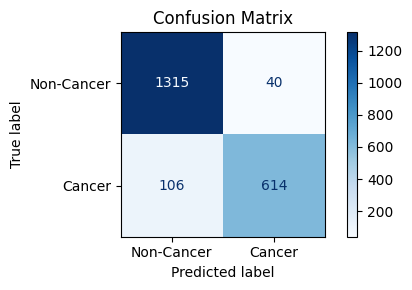

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


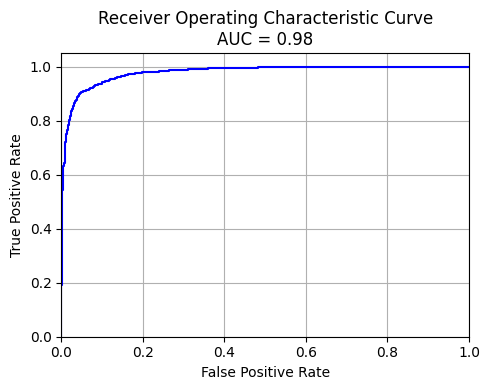

In [38]:
test_isCancer = test.copy()
test_isCancer['isCancerous'] = test_isCancer['isCancerous'].astype(str)

test_isCancer_datagen = ImageDataGenerator(rescale=1./255)

test_isCancer_generator = test_isCancer_datagen.flow_from_dataframe(
    dataframe=test_isCancer,
    directory='./Image_classification_data/patch_images/',
    x_col="ImageName",
    y_col="isCancerous",
    target_size=(27, 27),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

evaluate_binary_model(model_aug, test_isCancer_generator, test_labels)
evaluate_binary_matrix(model_aug, test_isCancer_generator, test_labels)
binary_roc_curve(model_aug, test_isCancer_generator, test_labels)


 ### 8.2 Multi-class Classification Model Evaluation (Cell Type)

Found 2075 validated image filenames belonging to 4 classes.
11/65 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.7657 - loss: 0.6164

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - categorical_accuracy: 0.7591 - loss: 0.6384
Test loss:0.8082
Test accuracy:0.6800

✅ Evaluating: Final Prediction Classification
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

Classification Report:
              precision    recall  f1-score   support

  epithelial       0.89      0.79      0.84       720
  fibroblast       0.65      0.63      0.64       459
inflammatory       0.61      0.87      0.71       592
      others       0.30      0.15      0.20       304

    accuracy                           0.68      2075
   macro avg       0.61      0.61      0.60      2075
weighted avg       0.67      0.68      0.66      2075

Macro F1 Score : 0.596

Confusion Matrix:


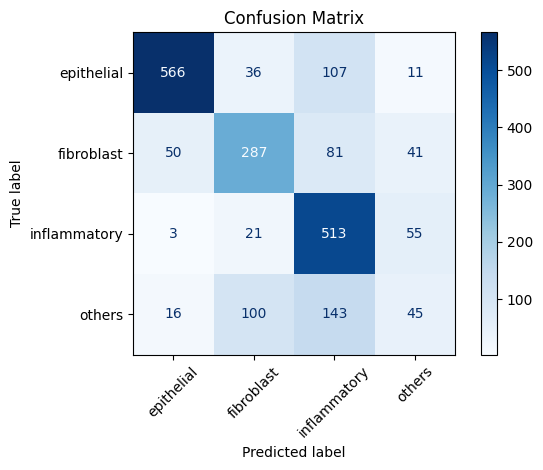

In [39]:
# Make explicit copies before modifying
test = test.copy()
test.loc[:, 'cellTypeName'] = test['cellTypeName'].astype(str)
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32
test_generator = test_datagen.flow_from_dataframe(
        dataframe=test,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
)

loss, accuracy = cellType_CNN_5.evaluate(test_generator, verbose=1)
print(f"Test loss:{loss:.4f}")
print(f"Test accuracy:{accuracy:.4f}")

final_pred = evaluate_model(test_generator, cellType_CNN_5, "Final Prediction Classification")


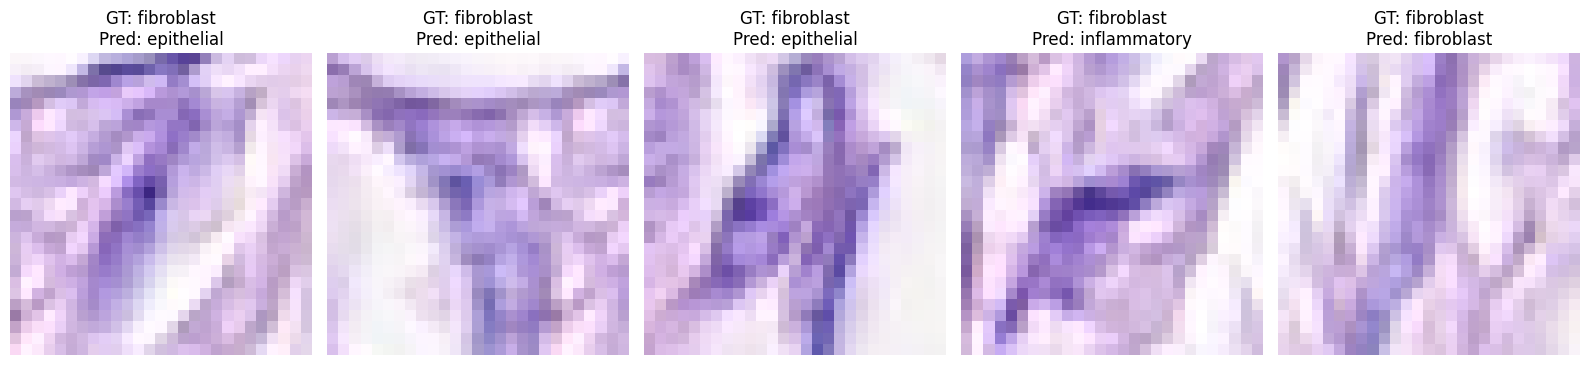

In [40]:
# Invert class_indices mapping from generator
inv_map = {v: k for k, v in test_generator.class_indices.items()}

plt.figure(figsize=(16, 4))
batches = 0

for x_batch, y_batch in test_generator:
    y_hat = ssl_model.predict(x_batch, verbose=0)
    x_batch = np.squeeze(x_batch)

    # Show 5 predictions
    for i in range(len(x_batch)):
        if batches >= 5:
            break

        img = x_batch[i]
        true_label = inv_map[np.argmax(y_batch[i])]
        pred_label = inv_map[np.argmax(y_hat[i])]

        plt.subplot(1, 5, batches + 1)
        plt.imshow(img)
        plt.title(f"GT: {true_label}\nPred: {pred_label}")
        plt.axis('off')

        batches += 1

    if batches >= 5:
        break

plt.tight_layout()
plt.show()


# 9. Comparative Analysis (Literature), Limitations & Future Work 

### 9.1 Comparative Analysis for Binary Classification

A study by [Budginaitė et al. (2021)](https://www.researchgate.net/publication/348411519_Deep_Learning_Model_for_Cell_Nuclei_Segmentation_and_Lymphocyte_Identification_in_Whole_Slide_Histology_Images) used the same dataset resource (CRCHistoPhenotypes) to predict whether a segmented nucleus is a lymphocyte or not. Their data preparation began with extracting 32×32 image patches from 256×256 histopathology tiles,  which is a larger input size compared to our 27×27 patches.

For classification model, they implemented a Multilayer Perceptron (MLP) with three hidden layers containing 4096, 2048, and 1024 neurons, respectively. The network used ReLU activations, batch normalization, and a dropout rate of 0.4 for regularization. Additionally, they evaluated a Convolutional Neural Network (CNN) consisting of four convolutional layers (with 16 or 32 kernels per layer), two max-pooling layers, and two dense layers, which achieved comparable performance to the MLP. The CNN architecture is similar to our binary classification model but includes slightly more convolutional layers.

Importantly, they applied data augmentation (including rotation, flipping, transposition, RGB/HED color jitter, and CLAHE) prior to training to expand the dataset. They also used Reinhard stain normalization to reduce color variability between datasets. This significantly improved classification performance, increasing the F1-score by 10 percentage points (from 0.70 to 0.80). In contrast, our model applies augmentation during training without expanding the dataset and uses only 1./255 rescaling prior to training.



 ### 9.2 Comparative Analysis for Multi-class Classification Model

Comparing to an academic study, [Basha et. al (2018)](https://arxiv.org/pdf/1810.02797) tackles a similar the goal of classifying images on the CRCHistoPhenotypes colon-cancer nuclei dataset to the 4 classes (epithelial, fibroblast, inflammatory, others). Basha used the full CRCHistoPhenotypes set of 22 444 nuclei patches across 4 classes, trained on 80% (17 955) and validated on 20% (4,489). However, Basha et al.’s “CNN-1” adapts an [AlexNet](https://viso.ai/deep-learning/alexnet/#:~:text=AlexNet%20is%20a%20Image%20Classification,CNN%20based%20Deep%20Neural%20Network.)-style network on 35×35 patches with no data augmentation or class balancing, trained for many epochs under SGD otimiser and evaluated by overall accuracy/weighted F1. They also used a classic 80% 20% split on their dataset, not concerned about splitting by PatinetID. In contrast, our CNN uses smaller 27×27 patches, patient-wise splits, light rotations/shifts/brightness augmentations, oversampling and class weights. It is primarily trained with Adam, early stopping and dropout, with macro F1 as the primary metric.

#### Limitations
- With the compared literature, because the input sizes, split strategies, augmentations, regularisation schemes, optimisers and evaluation metrics are all different, a direct numerical comparison (e.g. "our 0.71 macro F1 vs. their 0.79 weighted F1") isn't necessarily fair. Each model was trained and tested on its own parameters. 
- Moreover, through comparing our own models, when stepping up from model to model, we changed multiple parameters simultaneously. Eg. we augmented data or increased number of layers and changed filter numbers simultaneously. Therefore it is impossible to isolate which change drove the improvement.

#### Limitations
This successful study done by Basha et. al revealed our limitations on classifying the 4 classes. To name a few:
- **Limited dataset size:** Only a reduced subset of the 22 k nucleus patches was used, which may leave out valuable examples and hinder generalisation.
- **Class imbalance:** Despite up-sampling and weighting, rare classes (e.g. “others”) still have fewer true examples, making their F1 scores more volatile.
- **Architecture simplicity:** A 3-block CNN may lack capacity to learn highly complex patterns compared to deeper, optimised networks like RCCNet or AlexNet variants may help like Basha et. al study.
- **Some great techniques excluded:**: Semi-supervised and transfer-learning approaches were explored but not fully


#### Future Work
Moreover, Although we are not able to directly compare both our works, Basha et. al's study presents as a learning opportunity:
- Their success with deeper, larger networks suggests we could add extra convolutional blocks or bigger fully-connected layers to boost feature learning. 
- Using larger patch sizes (35×35 vs 27×27) might capture more contextual information. 
- Adopting their longer SGD training schedule and learning-rate decay could help our model converge more robustly. 
- Finally, extending to the larger dataset (beyond our reduced subset) or even semi-supervised approaches would test how extra samples improve generalisation. 